In [1]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import pickle
import nltk
from datasets import load_dataset
from collections import defaultdict
from os import listdir
from os.path import isfile, join

#force reimport
if 'pygents.aigents_api' in sys.modules:
    del sys.modules['pygents.aigents_api']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']
if 'pygents.text' in sys.modules:
    del sys.modules['pygents.text']
    
from pygents.text import url_lines
from pygents.aigents_api import TextMetrics, load_ngrams, punct, tokenize_re, build_ngrams, Learner
from pygents.plot import plot_dict, plot_dict_bars, matrix_plot
from pygents.util import dictcount, dictdict_div_dict, dict_of_dicts_compress_by_threshold, contains_seq

test_path = './temp/test/'

[nltk_data] Downloading package punkt to /Users/akolonin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
all_metrics = ['All-or-nothing_thinking','Fortune-telling','Mental_filter','Overgeneralization','Labeling',
          'Mind_Reading','Personalization','Emotional_Reasoning','Magnification','Should_statements']


def df2labeled(df,binary=False):
    data = []
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        if not binary:
            primary_distortion = row.iloc[2]  # The primary cognitive distortion from the 3rd column
            secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if present
        else:
            primary_distortion = 'Distortion' if row.iloc[2] != 'No Distortion' else 'No Distortion'
            secondary_distortion = None
        cats = (primary_distortion,) if secondary_distortion is None else (primary_distortion,secondary_distortion)
        data.append((text, tuple([c.replace(' ','_') for c in cats])))
    return data

def language_metrics(lang,metrics_filenames,path):
    metrics = {}
    for m in metrics_filenames:
        filename = metrics_filenames[m] if type(metrics_filenames) == dict else m
        metrics[m] = path + lang + '/' + filename + '.txt'
    return metrics

def our_evaluator_test(all_metrics,expected_distortions,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = True if (m in expected_distortions) else False
    return dic

def our_evaluator_tm(all_metrics,tm,text,threshold):
    metrics = tm.get_sentiment_words(text)
    dic = {}
    for m in all_metrics:
        dic[m] = True if m in metrics and metrics[m] > threshold else False
    return dic

def our_evaluator_true(all_metrics,tm,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = True
    return dic
    
def our_evaluator_false(all_metrics,tm,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = False
    return dic

def our_evaluator_random(all_metrics,tm,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = random.choice([True, False])
    return dic

def dictval(dic,key,val):
    return dic[key] if key in dic else val 

def pre_rec_f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return precision, recall, 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_tm_df(df,tm,evaluator,threshold,all_metrics,debug=False):
    true_positives = {}
    true_negatives = {}
    false_positives = {}
    false_negatives = {}
    pre = {}
    rec = {}
    f1 = {}
    acc = {}
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else 'No Distortion'  # The secondary distortion from the 4th column, if it exists
        ground_distortions = []
        if primary_distortion != 'No Distortion':
            ground_distortions.append(primary_distortion.replace(' ','_'))
        if secondary_distortion != 'No Distortion':
            ground_distortions.append(secondary_distortion.replace(' ','_'))

        if evaluator == our_evaluator_test:
            distortions_by_metric = evaluator(all_metrics,ground_distortions,text,threshold) #hack to test metrics
        else:
            distortions_by_metric = evaluator(all_metrics,tm,text,threshold)

        if debug:
            print(ground_distortions,'=>',[m for m in distortions_by_metric if distortions_by_metric[m]])
        
        for metric in distortions_by_metric:
            our_distortion = distortions_by_metric[metric]
            if (metric in ground_distortions) and our_distortion == True:
                dictcount(true_positives,metric)
            if (not metric in ground_distortions) and our_distortion == True:
                dictcount(false_positives,metric)
            if (not metric in ground_distortions) and our_distortion == False:
                dictcount(true_negatives,metric)
            if (metric in ground_distortions) and our_distortion == False:
                dictcount(false_negatives,metric)

    if debug:
        #print()
        print('TP:',true_positives)
        print('FP:',false_positives)
        print('TN:',true_negatives)
        print('FN:',false_negatives)
    
    for metric in all_metrics:
        precision, recall, f1score = pre_rec_f1_from_counts(dictval(true_positives,metric,0), dictval(true_negatives,metric,0), 
                                   dictval(false_positives,metric,0), dictval(false_negatives,metric,0))
        pre[metric] = precision
        rec[metric] = recall
        f1[metric] = f1score
        acc[metric] = (dictval(true_positives,metric,0) + dictval(true_negatives,metric,0)) / len(df)
    
    return pre, rec, f1, acc


def evaluate_metrics(tm, test_df, inclusion_threshold, detection_thresholds, all_scores = False):
        name = 'Multiclass FN'

        pres = [[] for i in range(len(all_metrics))]
        recs = [[] for i in range(len(all_metrics))]
        f1s = [[] for i in range(len(all_metrics))]
        accs = [[] for i in range(len(all_metrics))]

        for t in detection_thresholds:
            pre, rec, f1, acc = evaluate_tm_df(test_df,tm,our_evaluator_tm,t/100.0,all_metrics,debug=False)
            mi = 0
            for metric in all_metrics:
                pres[mi].append(pre[metric])
                recs[mi].append(rec[metric])
                f1s[mi].append(f1[metric])
                accs[mi].append(acc[metric])
                mi += 1

        if all_scores:
            matrix_plot(all_metrics, detection_thresholds, pres, 1.0, title = f'Precision: {name}, inclusion_threshold: {inclusion_threshold}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)
            matrix_plot(all_metrics, detection_thresholds, recs, 1.0, title = f'Recall: {name}, inclusion_threshold: {inclusion_threshold}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)
        matrix_plot(all_metrics, detection_thresholds, f1s, 1.0, title = f'F1: {name}, inclusion_threshold: {inclusion_threshold}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)

        
def evaluate_model(model, test_df, test_path, model_prefix, validation_fraction, inclusion_thresholds, detection_thresholds, all_scores = False):
    for inclusion_threshold in inclusion_thresholds:
        model.save(path=test_path,name=f'{model_prefix}-{inclusion_threshold}',metric='FN',inclusion_threshold=inclusion_threshold)
        all_metrics = sorted(model.export(metric='FN',inclusion_threshold=inclusion_threshold).keys() - {'No_Distortion'})
        tm = TextMetrics(language_metrics('',all_metrics,path=test_path+f'/{model_prefix}-{inclusion_threshold}'),encoding="utf-8",metric_logarithmic=True,debug=False)
        evaluate_metrics(tm, test_df, inclusion_threshold, detection_thresholds, all_scores = all_scores)
        

def full_test_circle(df, test_path, model_prefix, validation_fraction, inclusion_thresholds, detection_thresholds, all_scores = False):
    train_df = df[df.index % validation_fraction != 0]
    test_df = df[df.index % validation_fraction == 0]
    print(validation_fraction, len(df), len(train_df), len(test_df))

    learner=Learner()
    model = learner.learn(df2labeled(train_df), punctuation = punct, debug = False)
    print(model.labels)

    evaluate_model(model, test_df, test_path, model_prefix, validation_fraction, inclusion_thresholds, detection_thresholds, all_scores = all_scores)


In [3]:
all_metricsmap = {'All-or-nothing_thinking':'dichotomous-reasoning',
              'Fortune-telling':'fortune-telling',
              'Mental_filter':'mental-filtering',
              'Overgeneralization':'overgeneralizing',
              'Labeling':'labeling',
              'Mind_Reading':'mindreading',
              'Personalization':'personalizing',
              'Emotional_Reasoning':'emotional-reasoning',
              'Magnification':'magnification',
              'Should_statements':'should-statement'}

tm_base = TextMetrics(language_metrics('',all_metricsmap,path='data/models/distortions/ours')
                  ,encoding="utf-8",metric_logarithmic=True,debug=False)


In [4]:
ds = load_dataset(
    "halilbabacan/combined_synthetic_cognitive_distortions",
    split="train",
)

df = ds.to_pandas()
df = df.rename(columns={'text': 'Patient Question', 'label': 'Dominant Distortion'})
df.insert(1, 'Distorted part', value = np.nan)
df.insert(3, 'Secondary Distortion (Optional)', value = np.nan)
# Remove the row with index 738 because it contains a NaN in the text column
df = df.drop(index=738)


mapping = {
    "Labelling":            "Labeling",
    "Mental Filter":        "Mental filter",
    "Should Statements":    "Should statements",
    "All-or-Nothing Thinking": "All-or-nothing thinking"
}

df['Dominant Distortion'] = df['Dominant Distortion'].map(mapping).fillna(df['Dominant Distortion'])

df

Patient Question  Distorted part  \
0     John walked past me without saying a word He m...             NaN   
1     During the meeting, Sarah didn't look at me on...             NaN   
2     Mike didn't respond to my text right away He m...             NaN   
3     Jessica didn't smile when she saw me She must ...             NaN   
4     Tom didn't invite me to his party He must not ...             NaN   
...                                                 ...             ...   
4526  I’m a 21 year old female. I spent most of my l...             NaN   
4527  Now I am at university my peers around me all ...             NaN   
4528  He claims he’s severely depressed and has outb...             NaN   
4529  From the U.S.: I am a 21 year old woman who ha...             NaN   
4530  I recently moved out on my ex-roommate because...             NaN   

     Dominant Distortion  Secondary Distortion (Optional)  
0           Mind Reading                              NaN  
1           Mind Reading                              NaN  
2           Mind Reading                              NaN  
3           Mind Reading                              NaN  
4           Mind Reading                              NaN  
...                  ...                              ...  
4526       No Distortion                              NaN  
4527  Overgeneralization                              NaN  
4528       Mental filter                              NaN  
4529       No Distortion                              NaN  
4530       No Distortion                              NaN  

[4530 rows x 4 columns]

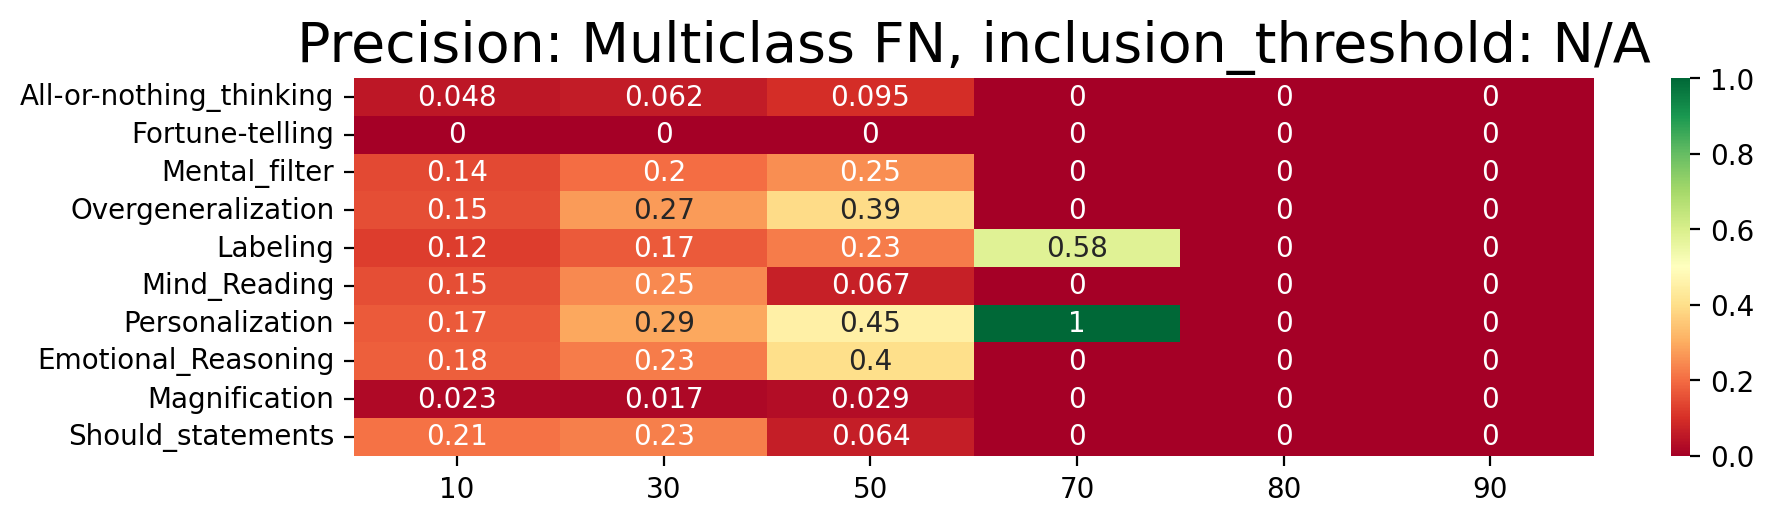

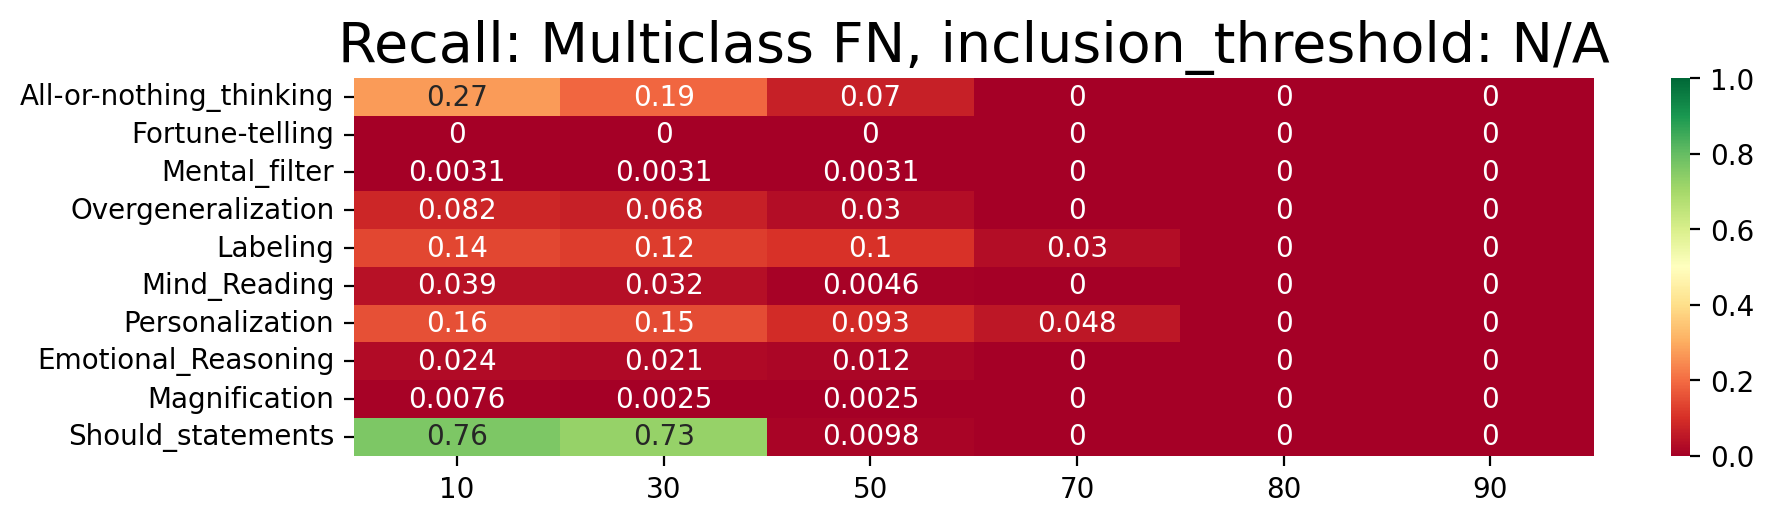

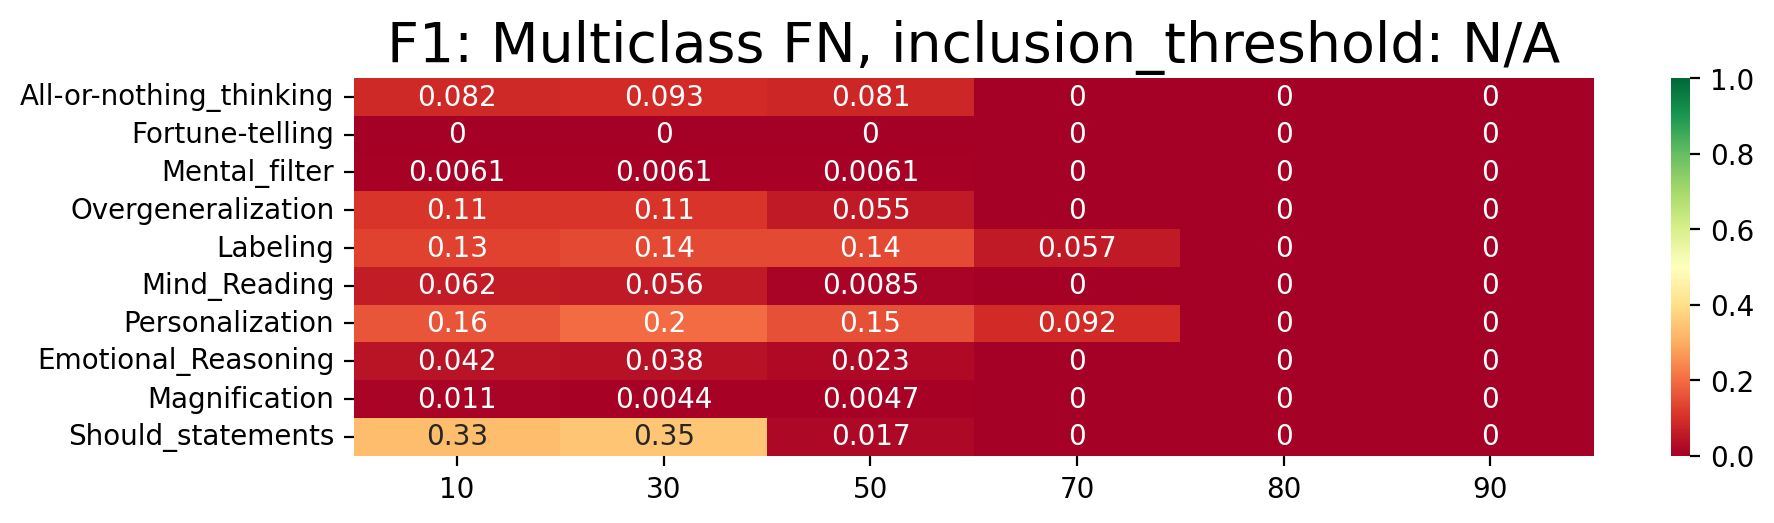

In [5]:
detection_thresholds = [10,30,50,70,80,90]
evaluate_metrics(tm_base, df, 'N/A', detection_thresholds, all_scores = True)


In [6]:
inclusion_thresholds = [10,30,50,70,80,90]
detection_thresholds = [10,30,50,70,80,90]


10 4530 4076 454
defaultdict(<class 'int'>, {'Mind_Reading': 401, 'Overgeneralization': 395, 'Magnification': 360, 'Labeling': 319, 'Personalization': 319, 'Fortune-telling': 306, 'Emotional_Reasoning': 303, 'Mental_filter': 292, 'Should_statements': 278, 'All-or-nothing_thinking': 264, 'No_Distortion': 839})


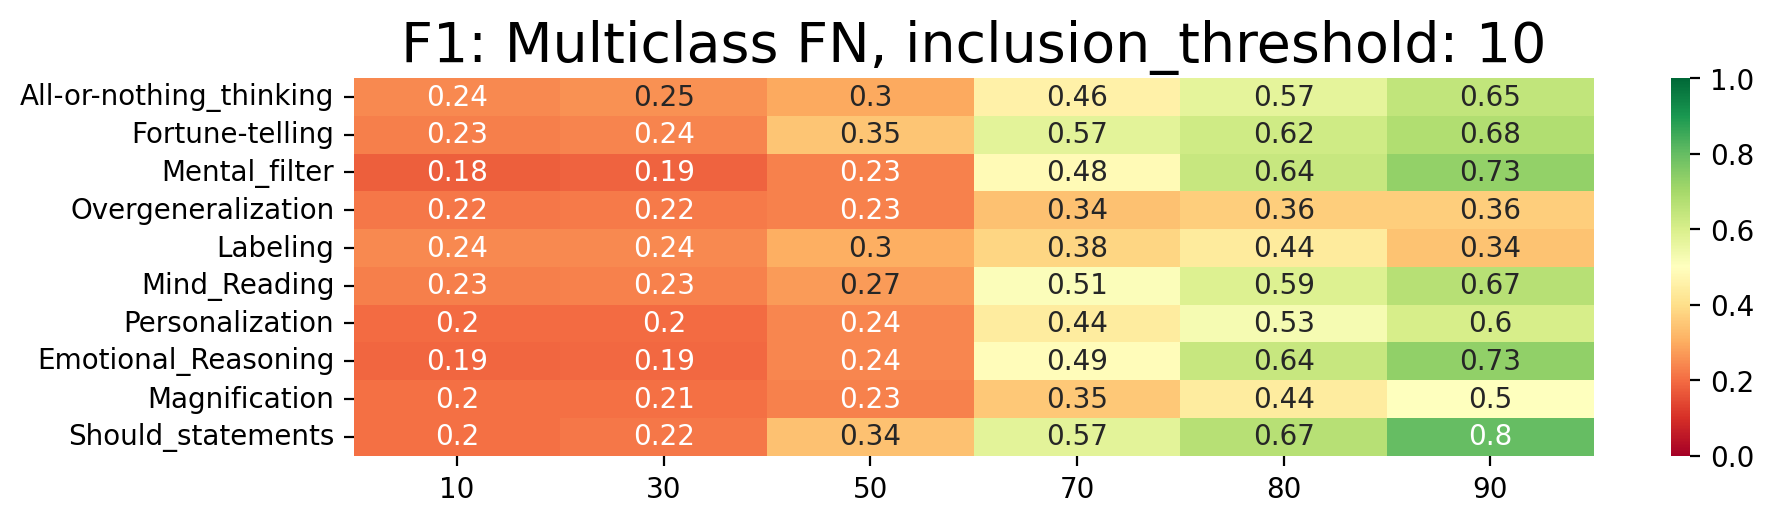

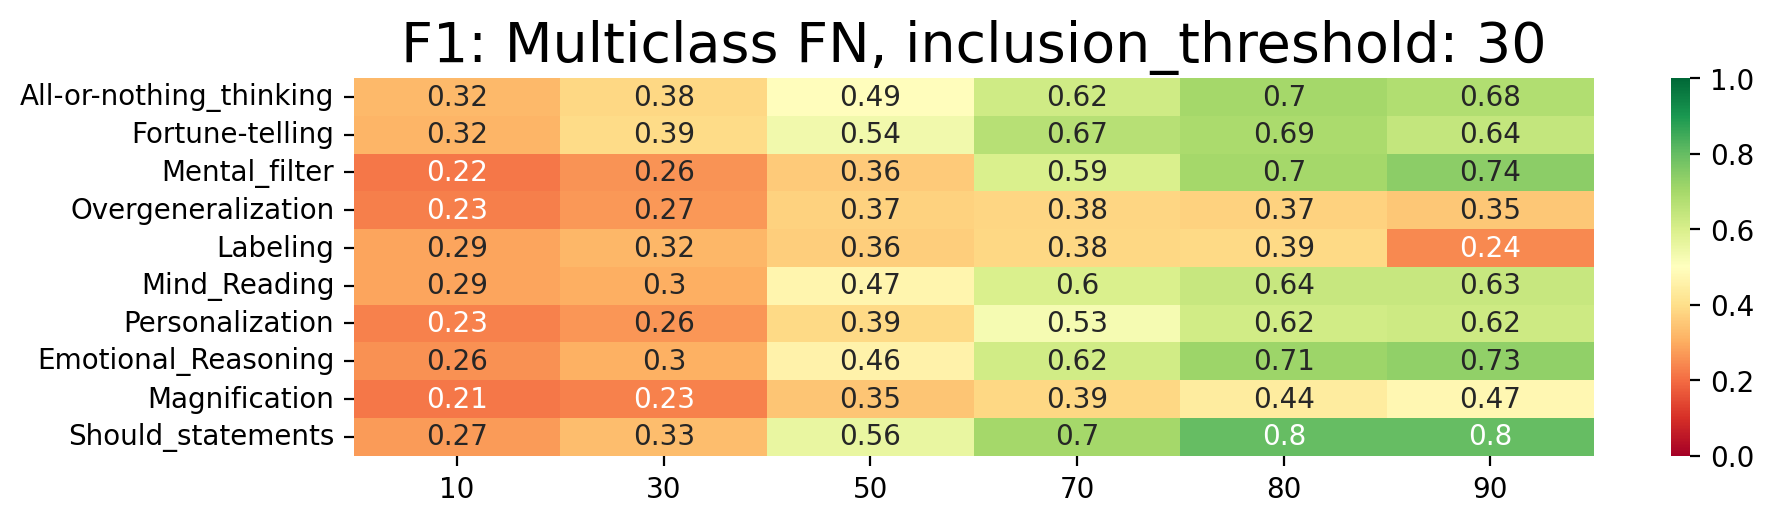

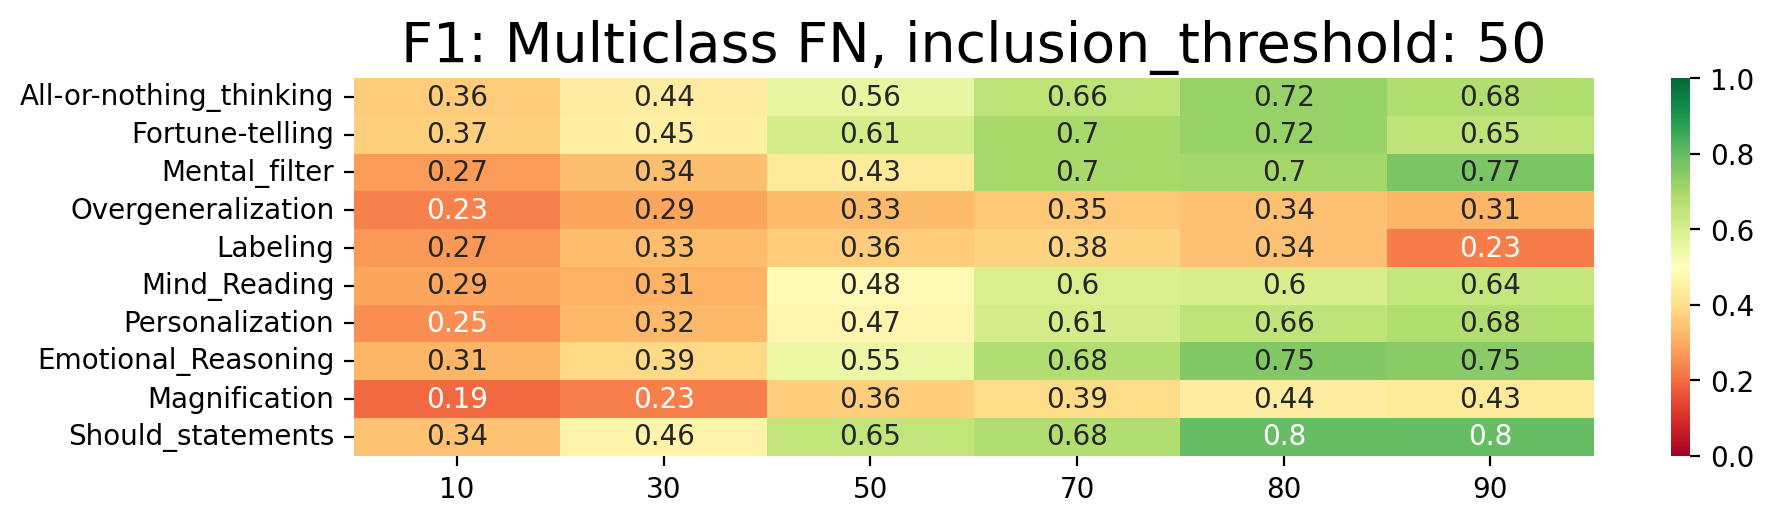

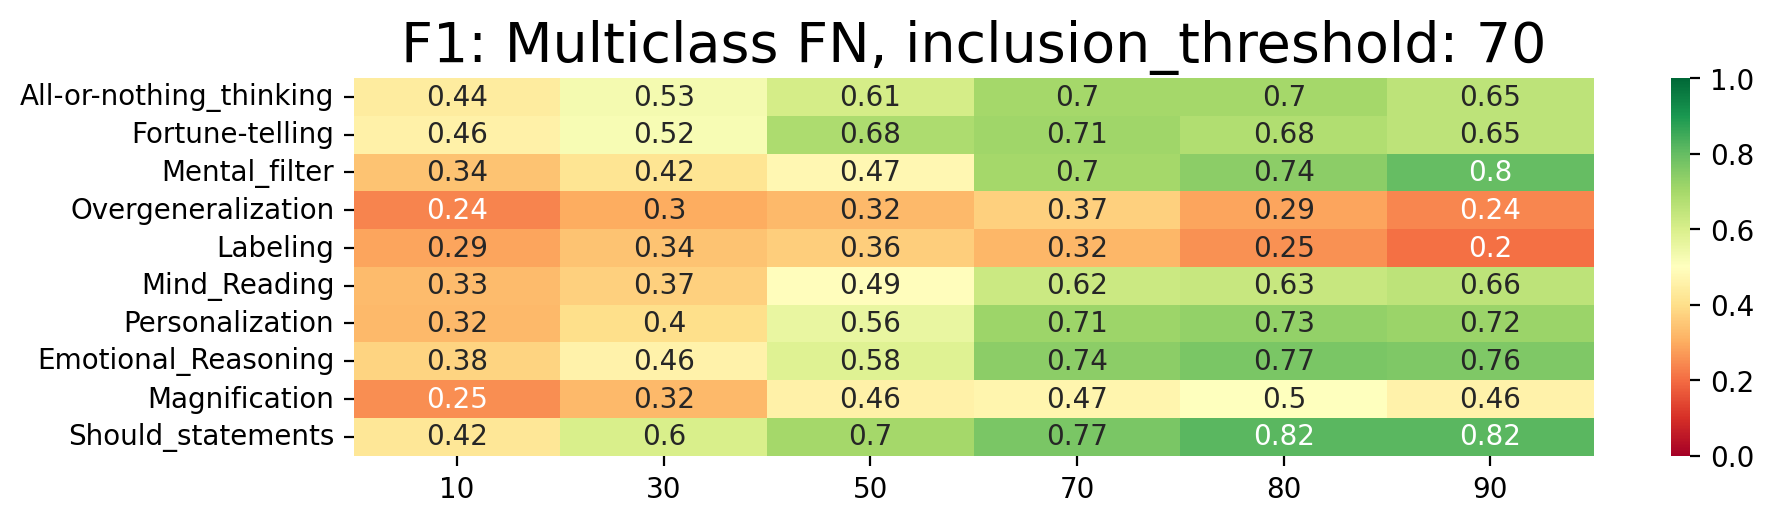

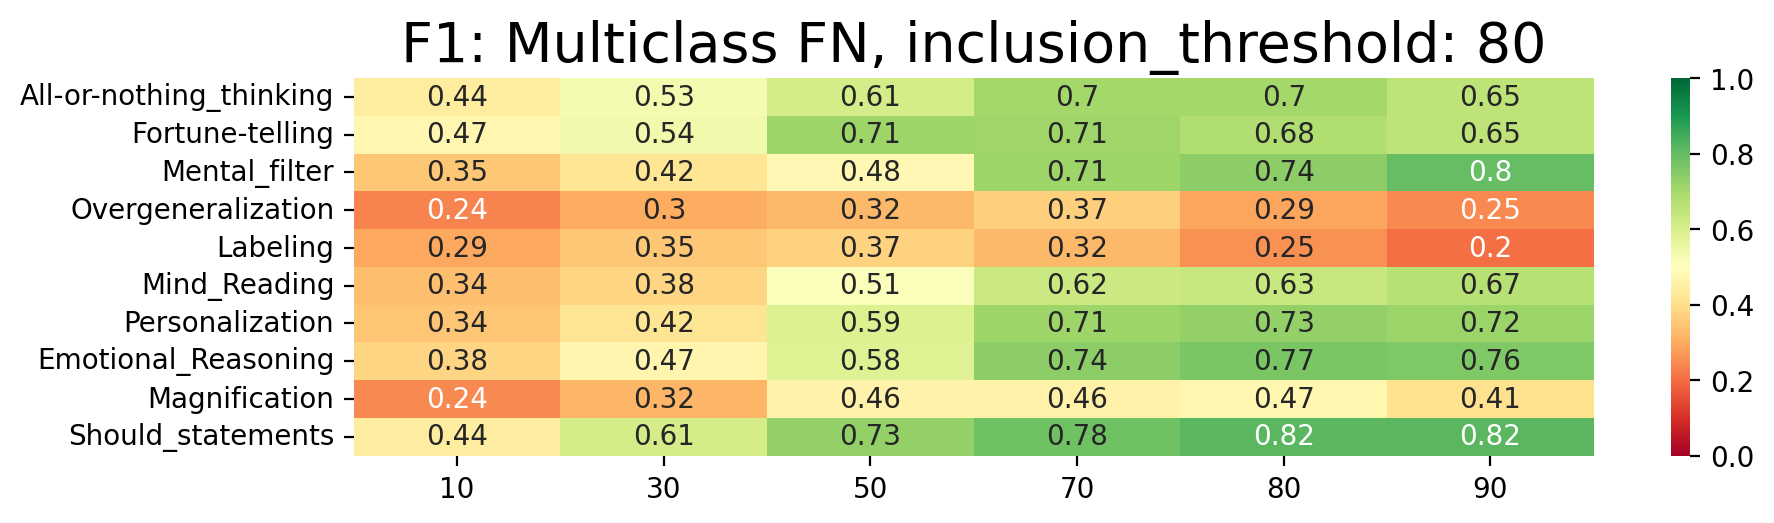

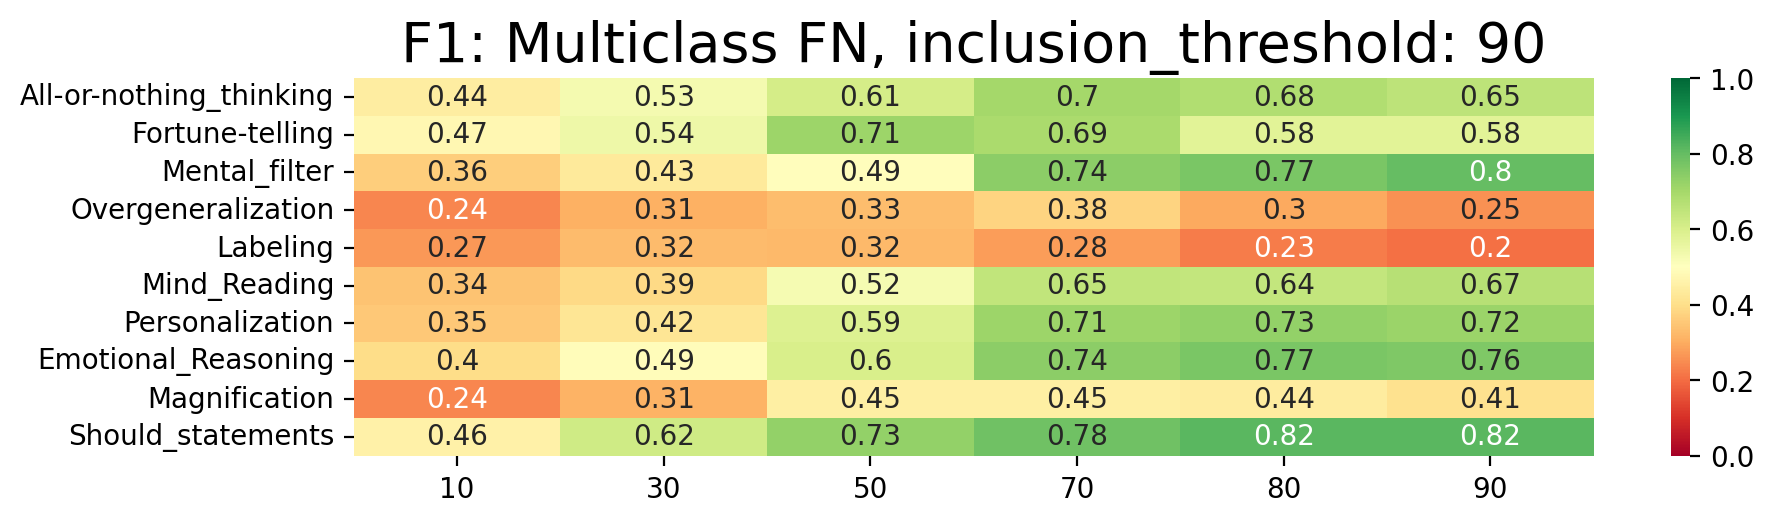

In [7]:
full_test_circle(df, test_path, 'multi-split-exp', 10, inclusion_thresholds, detection_thresholds)


10 4530 4076 454
defaultdict(<class 'int'>, {'Mind_Reading': 401, 'Overgeneralization': 395, 'Magnification': 360, 'Labeling': 319, 'Personalization': 319, 'Fortune-telling': 306, 'Emotional_Reasoning': 303, 'Mental_filter': 292, 'Should_statements': 278, 'All-or-nothing_thinking': 264, 'No_Distortion': 839})


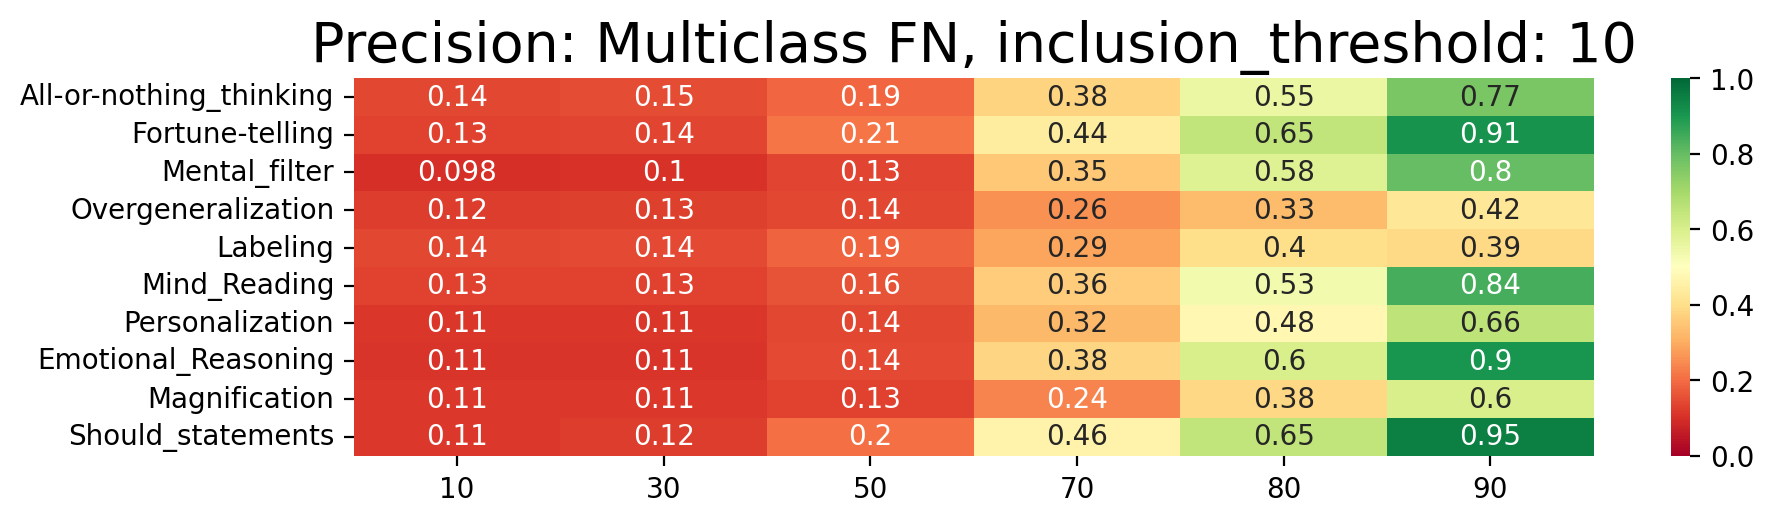

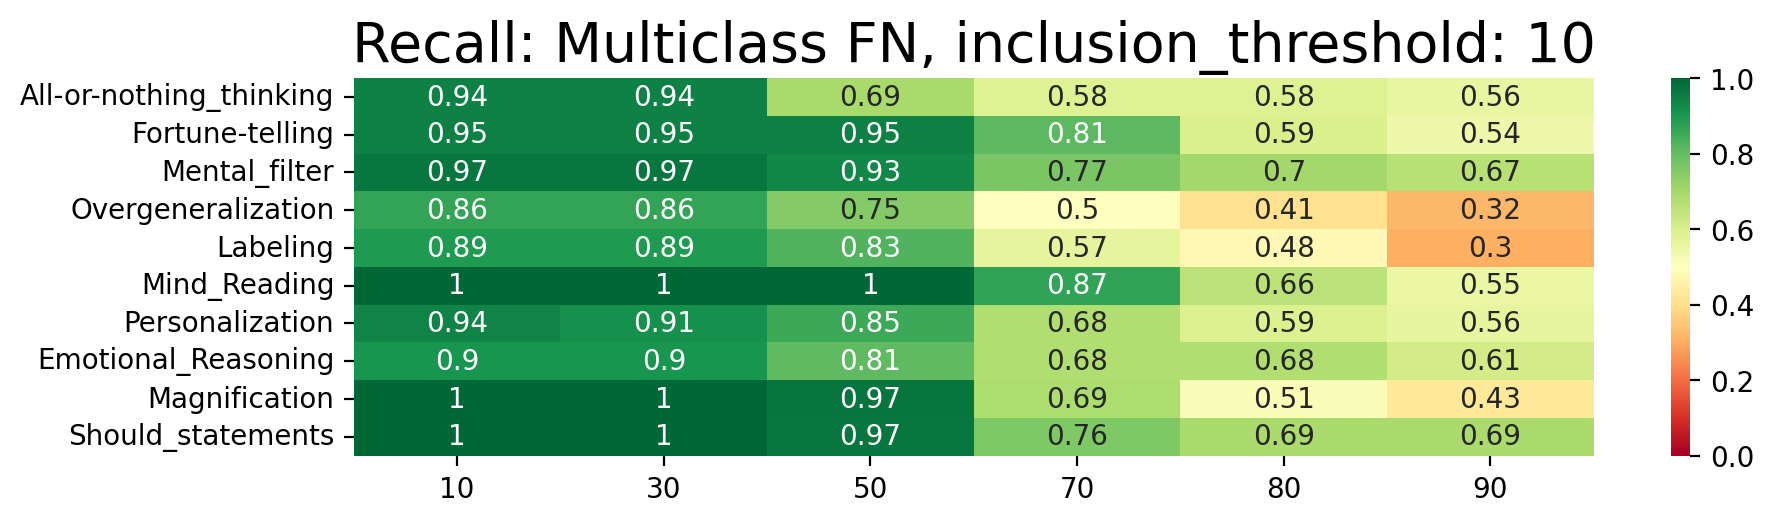

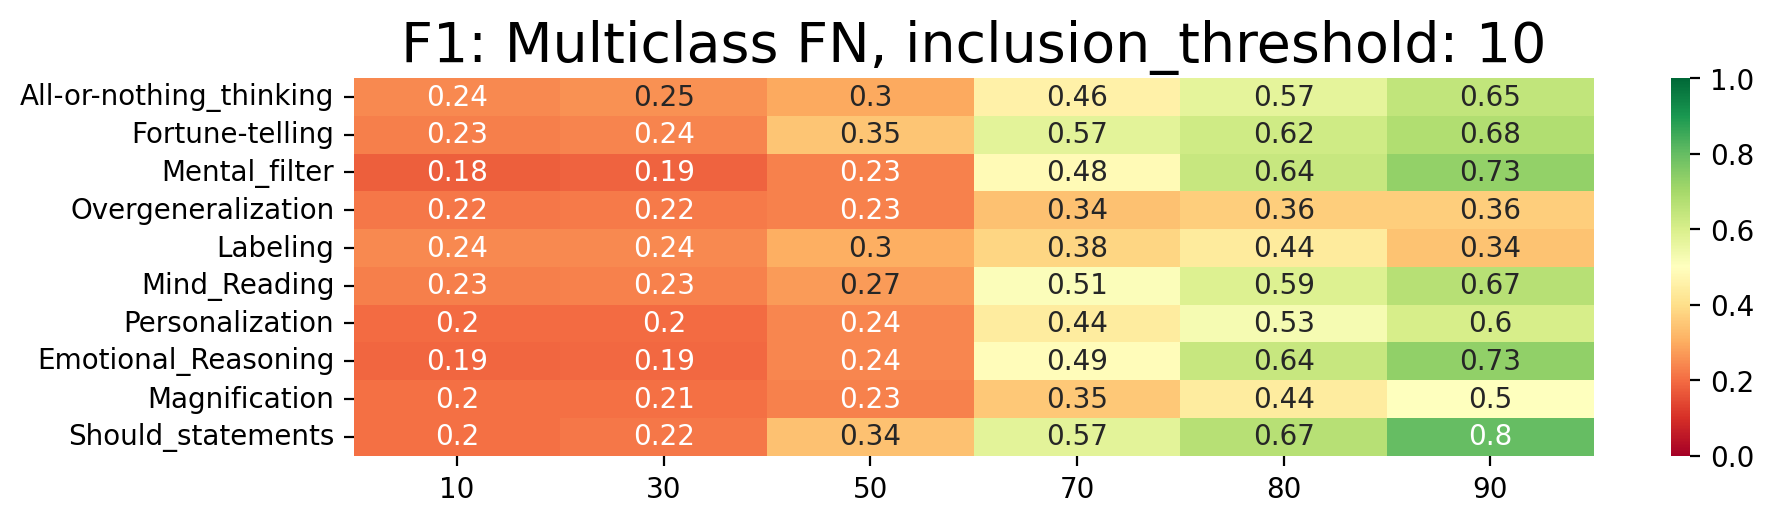

In [8]:
full_test_circle(df, test_path, 'multi-split-exp', 10, [10], detection_thresholds, all_scores = True)


10 4530 4076 454
defaultdict(<class 'int'>, {'Mind_Reading': 401, 'Overgeneralization': 395, 'Magnification': 360, 'Labeling': 319, 'Personalization': 319, 'Fortune-telling': 306, 'Emotional_Reasoning': 303, 'Mental_filter': 292, 'Should_statements': 278, 'All-or-nothing_thinking': 264, 'No_Distortion': 839})


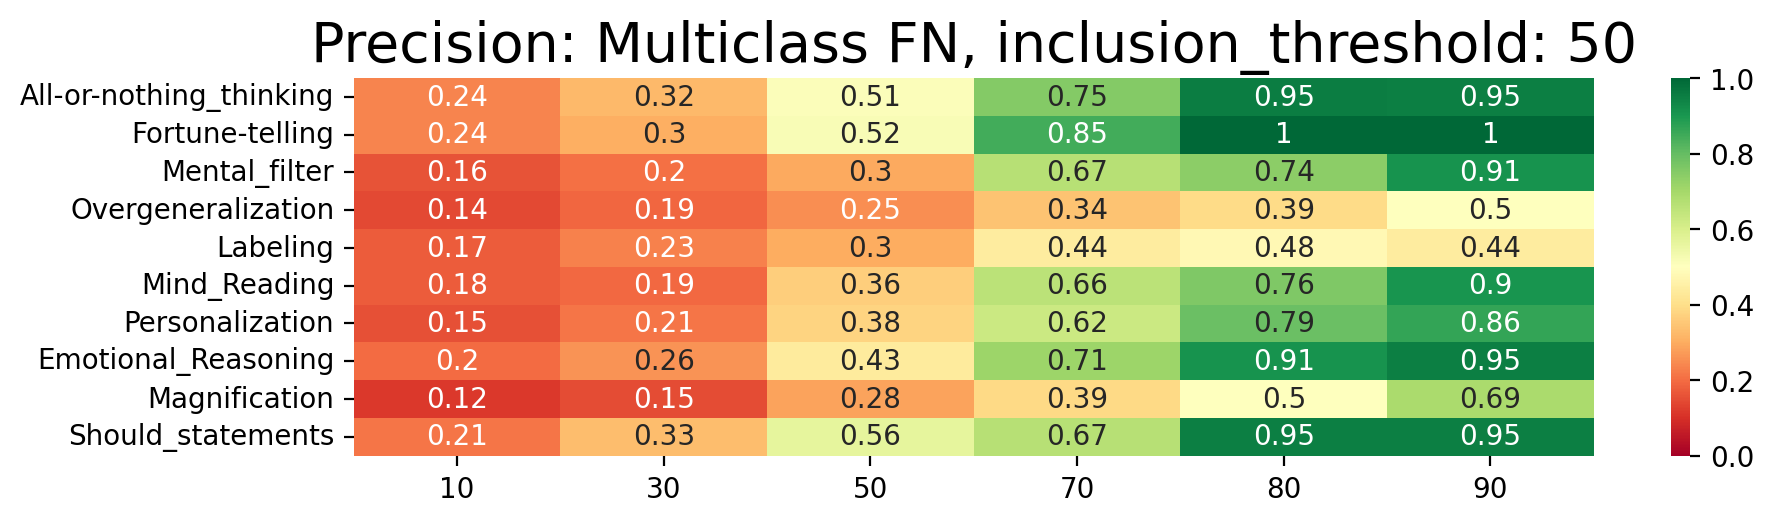

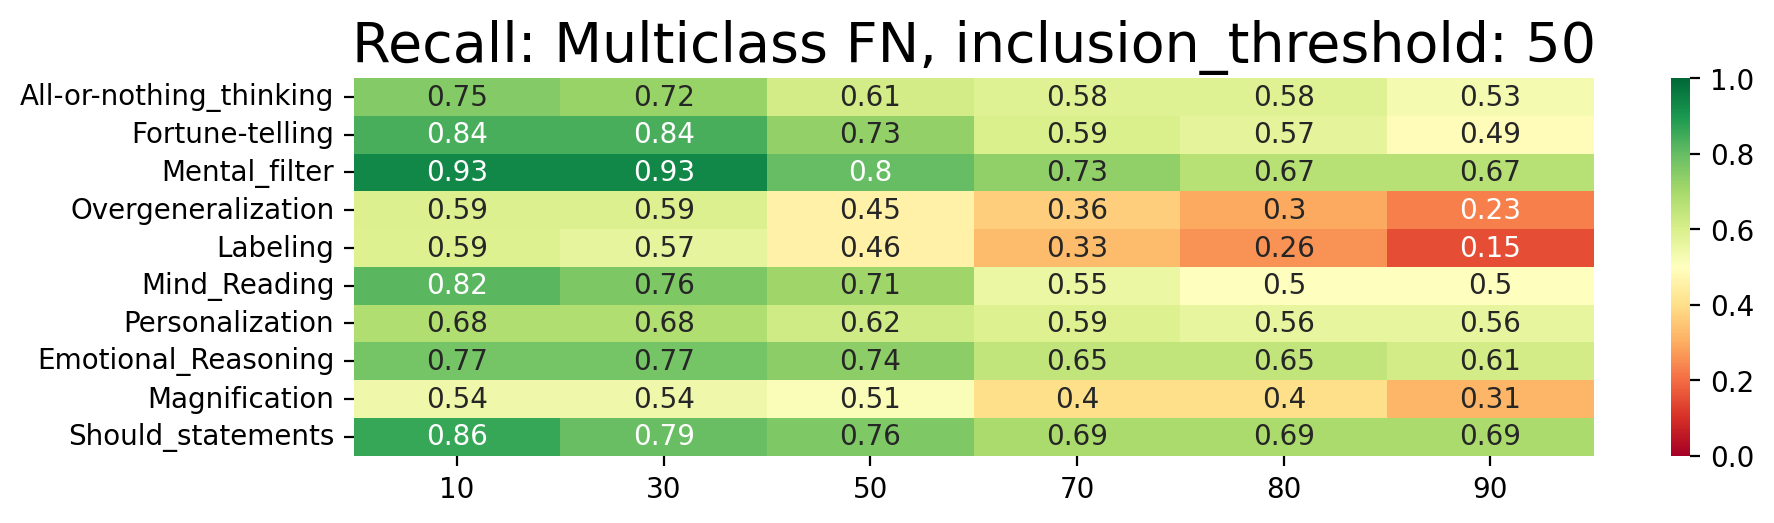

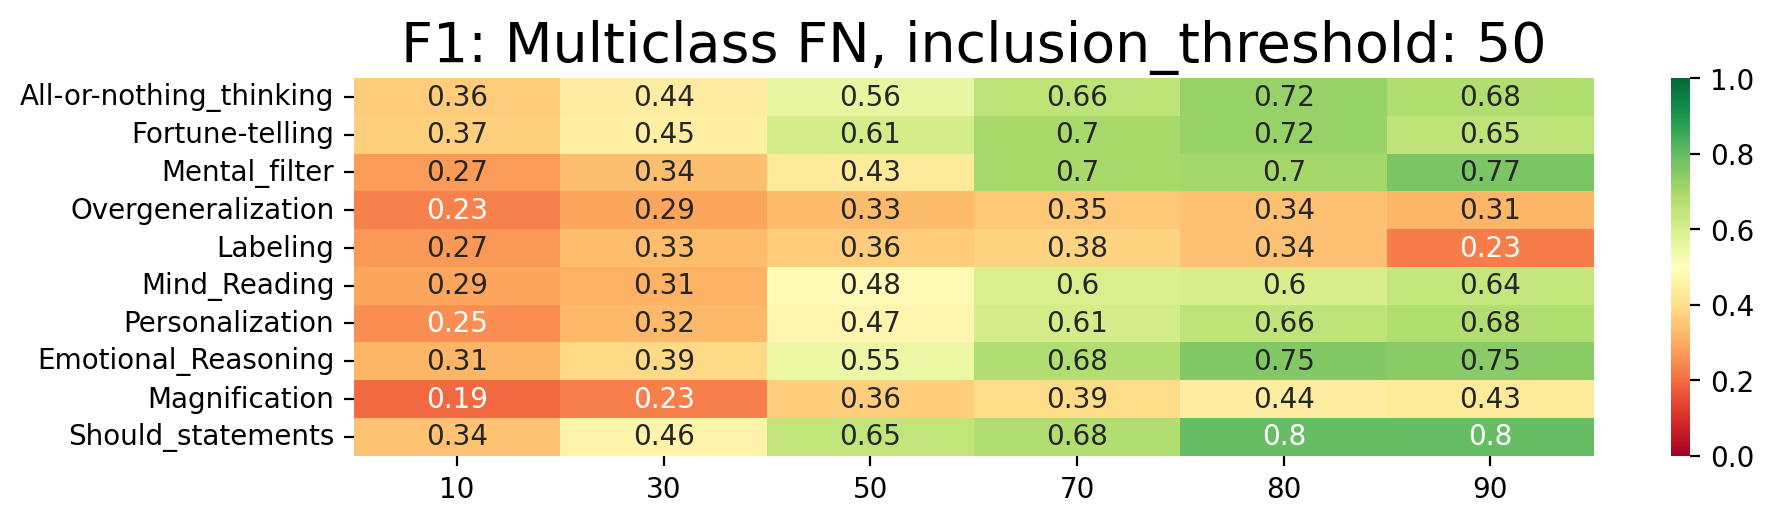

In [9]:
full_test_circle(df, test_path, 'multi-split-exp', 10, [50], detection_thresholds, all_scores = True)


10 4530 4076 454
defaultdict(<class 'int'>, {'Mind_Reading': 401, 'Overgeneralization': 395, 'Magnification': 360, 'Labeling': 319, 'Personalization': 319, 'Fortune-telling': 306, 'Emotional_Reasoning': 303, 'Mental_filter': 292, 'Should_statements': 278, 'All-or-nothing_thinking': 264, 'No_Distortion': 839})


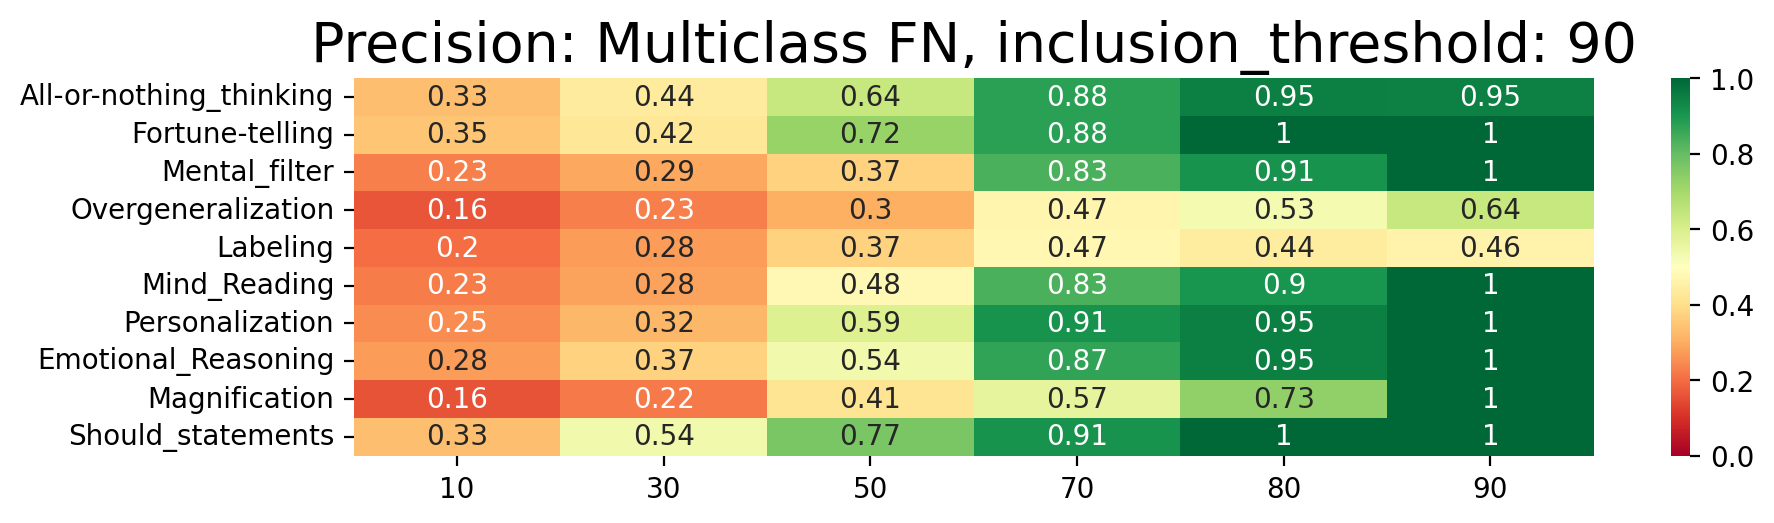

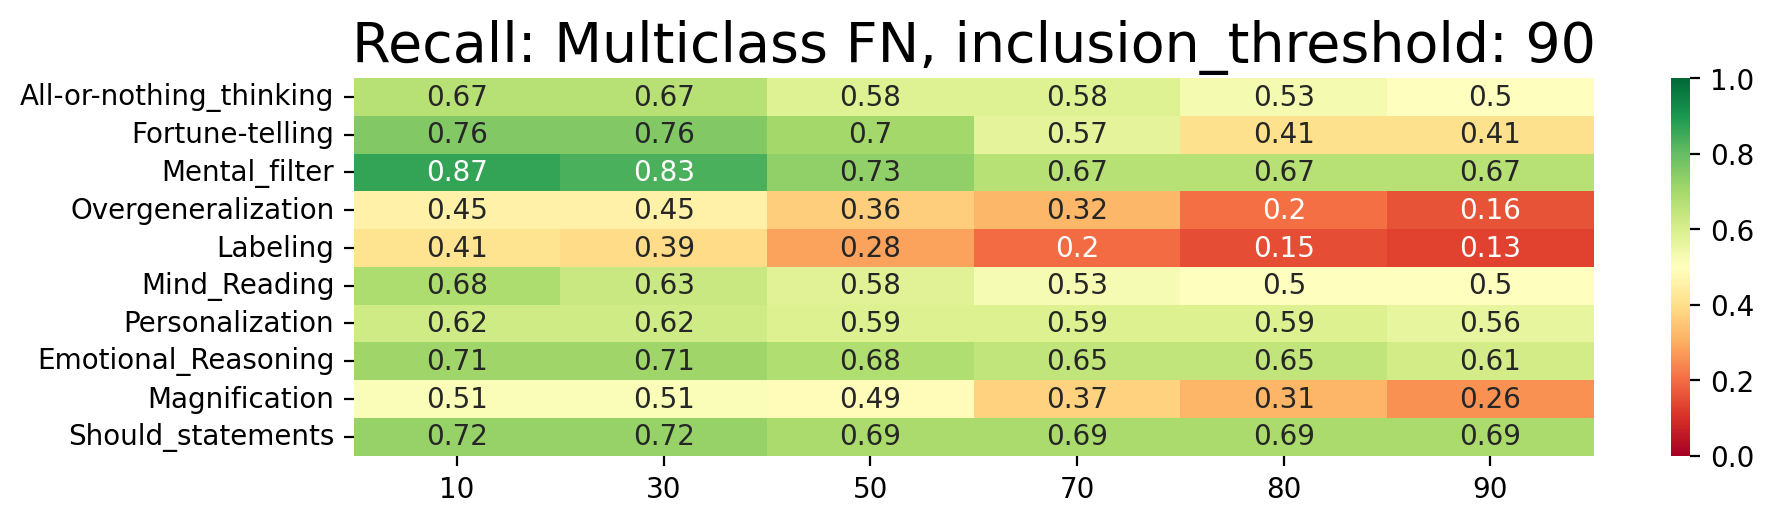

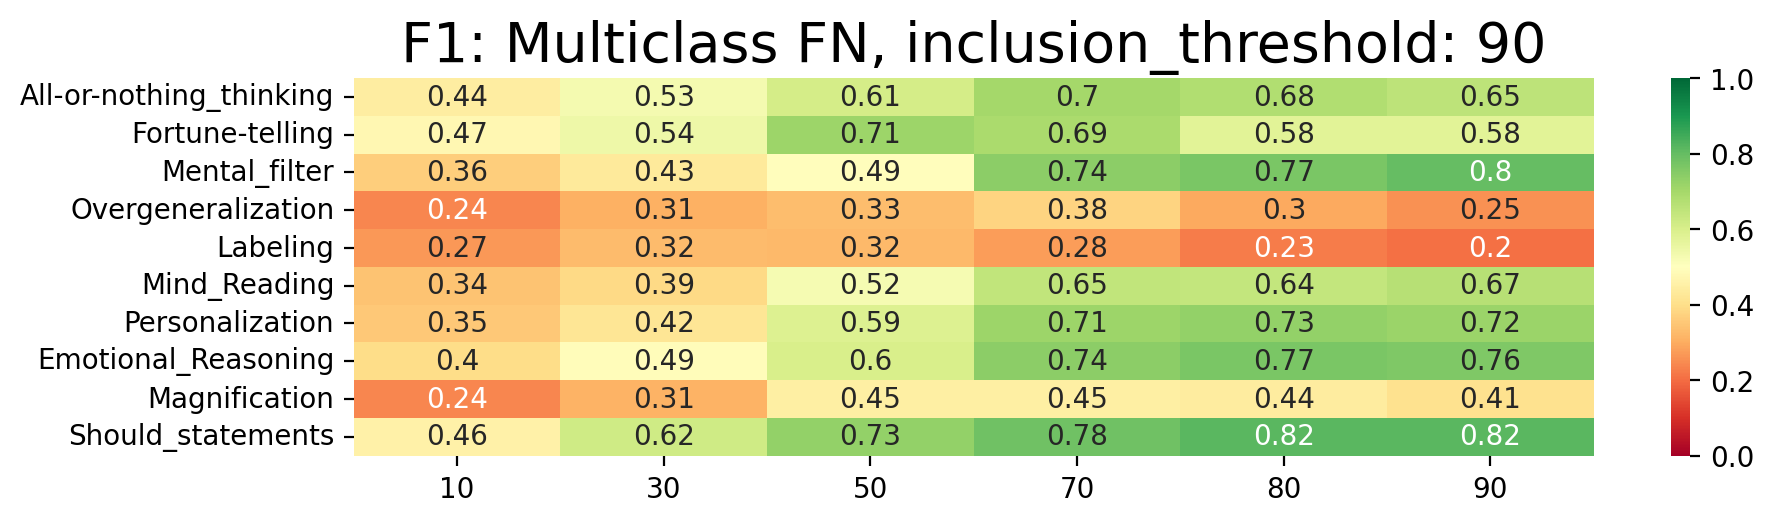

In [10]:
full_test_circle(df, test_path, 'multi-split-b2', 10, [90], detection_thresholds, all_scores = True)


In [11]:
tm10 = TextMetrics(language_metrics('',all_metrics,path=test_path+f'/multi-split-exp-10'),encoding="utf-8",metric_logarithmic=True,debug=False)
tm50 = TextMetrics(language_metrics('',all_metrics,path=test_path+f'/multi-split-exp-50'),encoding="utf-8",metric_logarithmic=True,debug=False)
tm90 = TextMetrics(language_metrics('',all_metrics,path=test_path+f'/multi-split-exp-90'),encoding="utf-8",metric_logarithmic=True,debug=False)


In [12]:
#[t for t in tm.metrics['Labeling'] if contains_seq(t, ("i'm", "so"))]
print(len([t for t in tm10.metrics['Labeling'] if contains_seq(t, ("i'm", "so"))]))
print(len([t for t in tm50.metrics['Labeling'] if contains_seq(t, ("i'm", "so"))]))
print(len([t for t in tm90.metrics['Labeling'] if contains_seq(t, ("i'm", "so"))]))

print(len([t for t in tm10.metrics['Labeling'] if contains_seq(t, ("i'm", "so")) and len(t)<=2]))
print(len([t for t in tm50.metrics['Labeling'] if contains_seq(t, ("i'm", "so")) and len(t)<=2]))
print(len([t for t in tm90.metrics['Labeling'] if contains_seq(t, ("i'm", "so")) and len(t)<=2]))


197
194
179
1
1
0


In [13]:
[t for t in tm10.metrics['Labeling'] if contains_seq(t, ("i'm", "so")) and len(t)<=3]

[('lunch', "i'm", 'so'),
 ('instructions', "i'm", 'so'),
 ("i'm", 'so', 'careless'),
 ('promise', "i'm", 'so'),
 ('file', "i'm", 'so'),
 ('call', "i'm", 'so'),
 ('way', "i'm", 'so'),
 ('question', "i'm", 'so'),
 ("i'm", 'so', 'scatterbrained'),
 ('movie', "i'm", 'so'),
 ('balance', "i'm", 'so'),
 ('workload', "i'm", 'so'),
 ("i'm", 'so'),
 ('event', "i'm", 'so'),
 ('conversation', "i'm", 'so'),
 ('task', "i'm", 'so'),
 ('project', "i'm", 'so'),
 ('notes', "i'm", 'so'),
 ('password', "i'm", 'so'),
 ('composure', "i'm", 'so'),
 ('flight', "i'm", 'so'),
 ('wallet', "i'm", 'so'),
 ('enough', "i'm", 'so'),
 ("i'm", 'so', 'irresponsible'),
 ("i'm", 'so', 'unlucky'),
 ('subscription', "i'm", 'so'),
 ('keys', "i'm", 'so'),
 ('pace', "i'm", 'so'),
 ('time', "i'm", 'so'),
 ('document', "i'm", 'so'),
 ('appointment', "i'm", 'so'),
 ('meeting', "i'm", 'so'),
 ('bill', "i'm", 'so'),
 ("i'm", 'so', 'undisciplined'),
 ('details', "i'm", 'so'),
 ("i'm", 'so', 'timid'),
 ("i'm", 'so', 'dumb'),
 ("i'm",

In [14]:
test_df = df[df.index % 10 == 0]


In [15]:
tm = tm90

fps = 0
fns = 0
for tc in df2labeled(test_df):
    text = tc[0]
    ngrams = {}
    labels = tm.get_sentiment_words(text,ngrams,priority=True)
    FP = 'Labeling' in labels and (not 'Labeling' in tc[1])
    FN = (not 'Labeling' in labels) and 'Labeling' in tc[1]
    if FP:
        fps += 1
    if FN:
        fns += 1
    #if FP or FN:
    if FP:
        #pass
        print('FP' if FP else 'FN',tc[0])
        print(tc[1])
        print(labels,ngrams)
        print()
print(fps,fns)

FP I was nervous during the interview I'm terrible at interviews
('Overgeneralization',)
{'Labeling': 1.1} {'Labeling': [('i', 'was', 'nervous', 'during'), ('was', 'nervous', 'during', 'the'), ('nervous', 'during', 'the', 'interview'), ('during', 'the', 'interview', "i'm")]}

FP I didn't finish the marathon I'm not a good runner
('Overgeneralization',)
{'Labeling': 1.04} {'Labeling': [("didn't", 'finish', 'the', 'marathon'), ('finish', 'the', 'marathon', "i'm"), ('the', 'marathon', "i'm", 'not')]}

FP I forgot to call back I'm always forgetting important things
('Overgeneralization',)
{'Labeling': 0.95, 'Overgeneralization': 0.81} {'Labeling': [('forgot', 'to', 'call', 'back'), ('to', 'call', 'back', "i'm")], 'Overgeneralization': [('always', 'forgetting'), ('important', 'things')]}

FP I couldn't understand the instructions I'm not good at following directions
('Overgeneralization',)
{'Labeling': 1.02, 'Overgeneralization': 1.02} {'Labeling': [('i', "couldn't", 'understand', 'the'), (

FP Hello, I have been dealing with this problem, I’m pretty worried I might be a Pedophile, I am 16 and shouldn’t really be worrying about this I feel like but it keeps eating at me, I’ve never had the desire to touch a kid, and when I did it was before I hit puberty (as a kid myself) when I was 14 I was in a relationship with someone a little older than me (she would have been around 15) I honestly felt like I was in love with this person, shortly after that we broke up and it honestly emotionally destroyed me for a while, I’ve been diagnosed with Chronic Depression and Social Anxiety, my mother is pretty certain I have OCD just by the way I talk about things.
('Overgeneralization',)
{'Should_statements': 0.25, 'Labeling': 0.25, 'Mental_filter': 0.19} {'Should_statements': [('be', 'worrying', 'about')], 'Labeling': [('this', 'i', 'feel')], 'Mental_filter': [('it', 'honestly')]}

FP I’m very bold in my expression I am calm but usually I will be insulting and ask them why they did it. I

FP From a teen in Italy: i guess i have to began from the beginning,when i guess is started everything..so i was always been an introvert kid,loving nature and especially dogs. So in school they began to make fun of me because i was a bit chubby,then last year ive been recovered from anorexia,and because i love dogs(since i was a kid i always had this special bond with dogs and actually during anorexia my two dogs saved my life) anyway they torturing me and keep telling me that i was ugly,and that my life price was 0,2 cent(really low…means that the trash was more important than my life) so i start cutting,but never had suicide attempt.
('No_Distortion',)
{'Mind_Reading': 0.36, 'Personalization': 0.25, 'Emotional_Reasoning': 0.36, 'Labeling': 0.19, 'Magnification': 0.12, 'Should_statements': 0.12} {'Mind_Reading': [('of', 'me', 'because'), ('more', 'important', 'than')], 'Personalization': [('and', 'because', 'i')], 'Emotional_Reasoning': [('keep', 'telling', 'me'), ('and', 'that', 'my

FP Your opinion? My partner is contradictory and critical, but at the same time gets very upset if any of her ideas or decisions are questioned in any way. Examples: She will ridicule any book I am reading unless it is one recommended by her. If it is not a subject that interests her, especially technical books, she will describe the book as childish rubbish. The same with any TV program or film. She is an aspirational vegetarian. If I have meat and she has vegetarian she has spent the evening — while I am eating — asking how I could eat dead rotting flesh, how do I feel having caused the death of  a living being just for my gratification etc. The following week she will buy, cook and eat chicken and say how tasty it is. Sex. This has now ceased. Very often she has not only rejected me, but says that I am disgusting for wanting sex, “Don’t come near me. Don’t you dare touch me”etc — almost hysterical. A couple of days later she will start crying and ask why don’t I make love to her any

3 4530 3020 1510
defaultdict(<class 'int'>, {'Mind_Reading': 287, 'Overgeneralization': 293, 'Magnification': 270, 'Labeling': 246, 'Personalization': 228, 'Fortune-telling': 231, 'Emotional_Reasoning': 219, 'Mental_filter': 223, 'Should_statements': 213, 'All-or-nothing_thinking': 198, 'No_Distortion': 612})


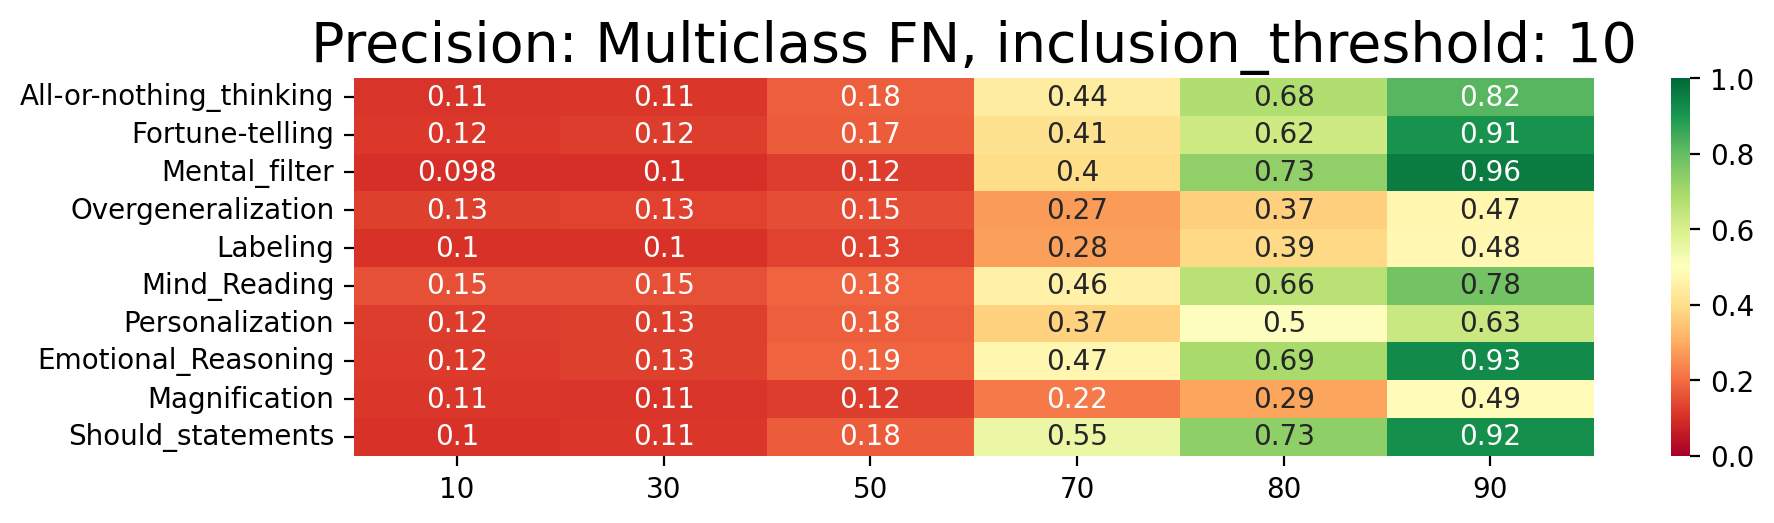

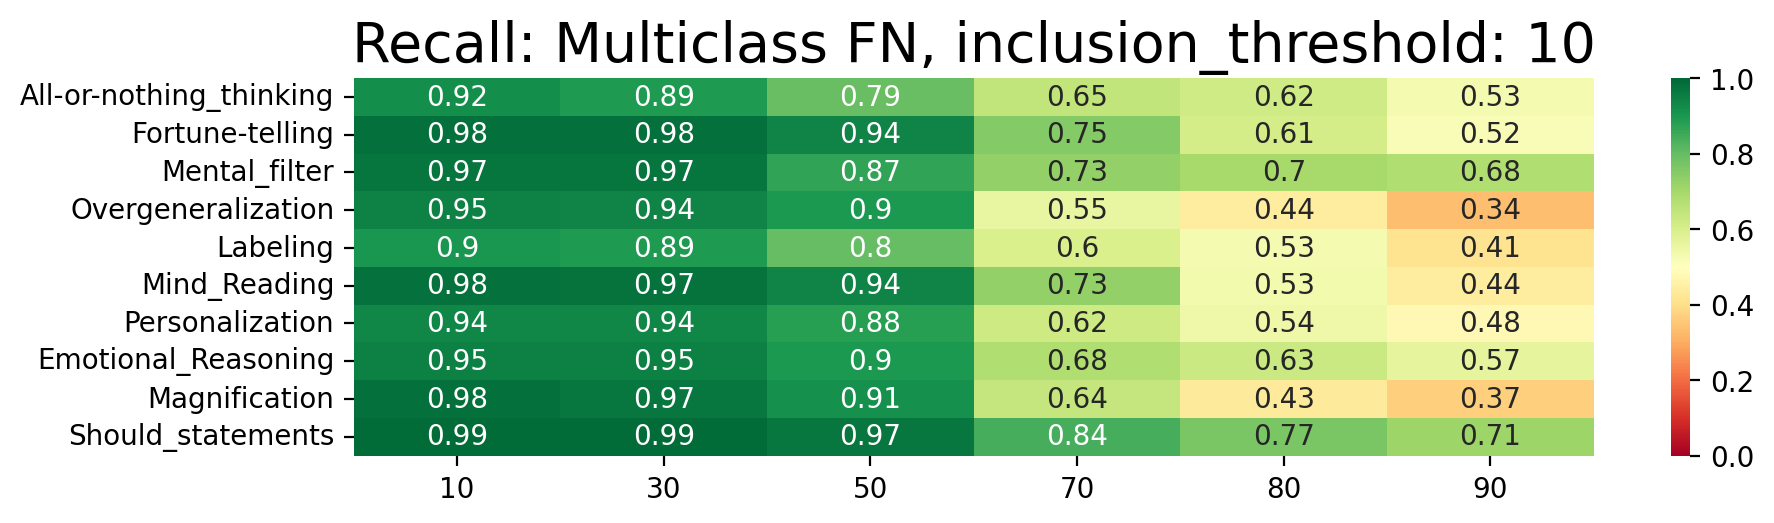

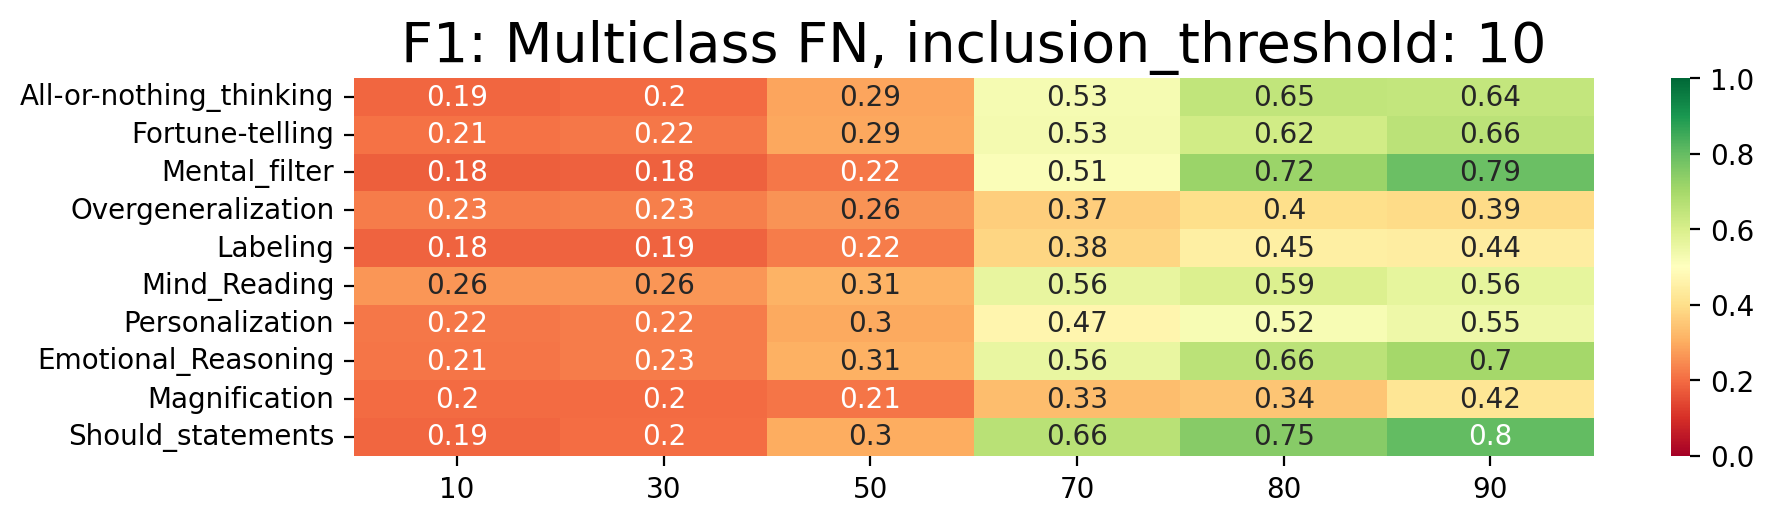

3 4530 3020 1510
defaultdict(<class 'int'>, {'Mind_Reading': 287, 'Overgeneralization': 293, 'Magnification': 270, 'Labeling': 246, 'Personalization': 228, 'Fortune-telling': 231, 'Emotional_Reasoning': 219, 'Mental_filter': 223, 'Should_statements': 213, 'All-or-nothing_thinking': 198, 'No_Distortion': 612})


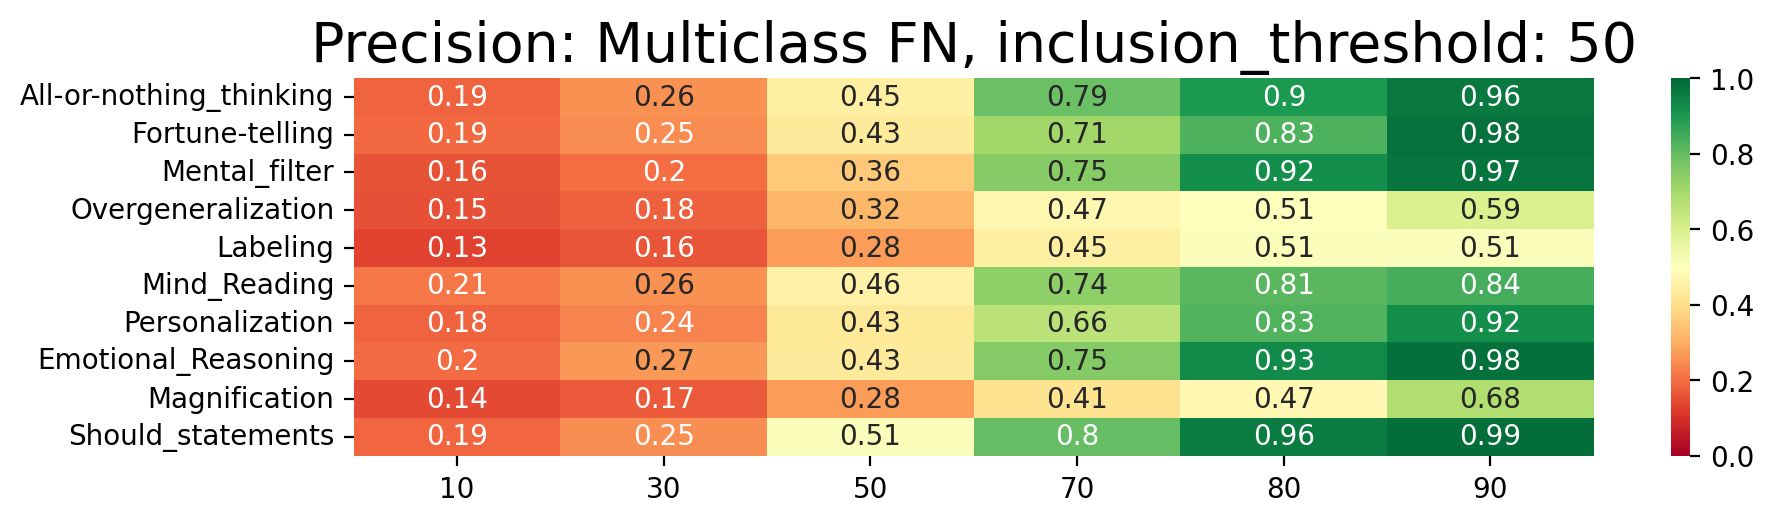

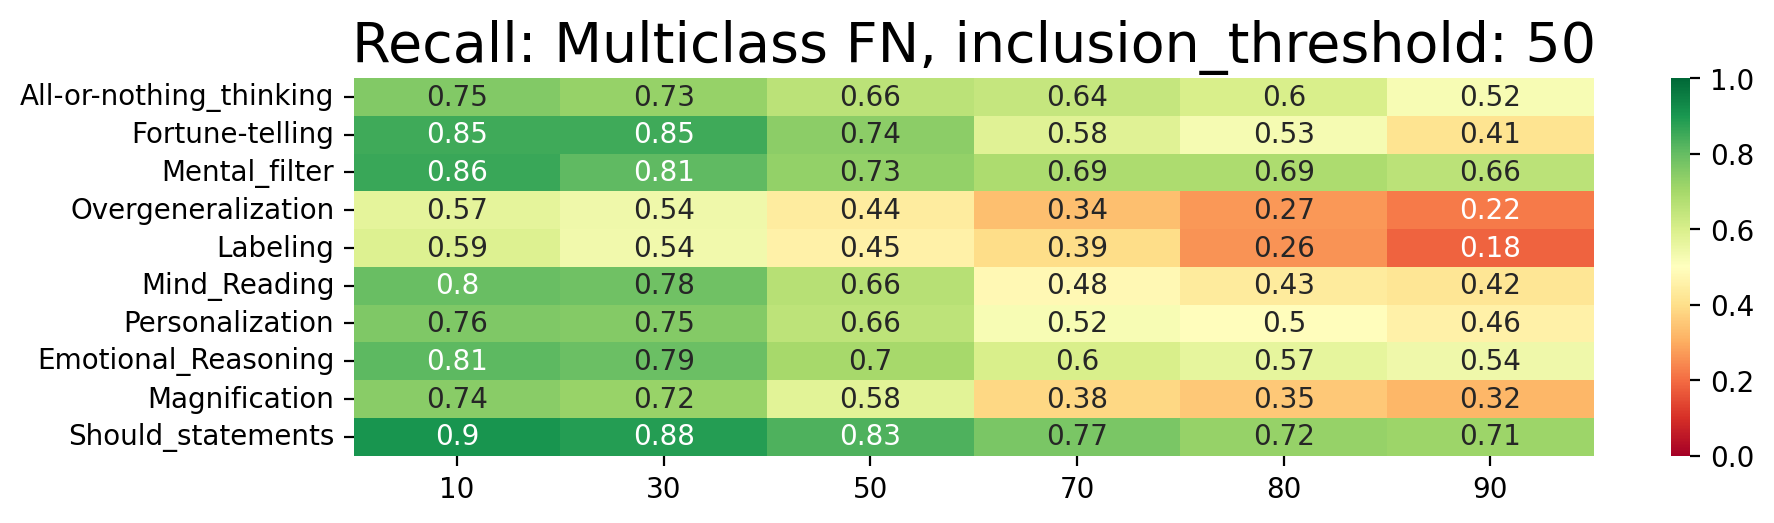

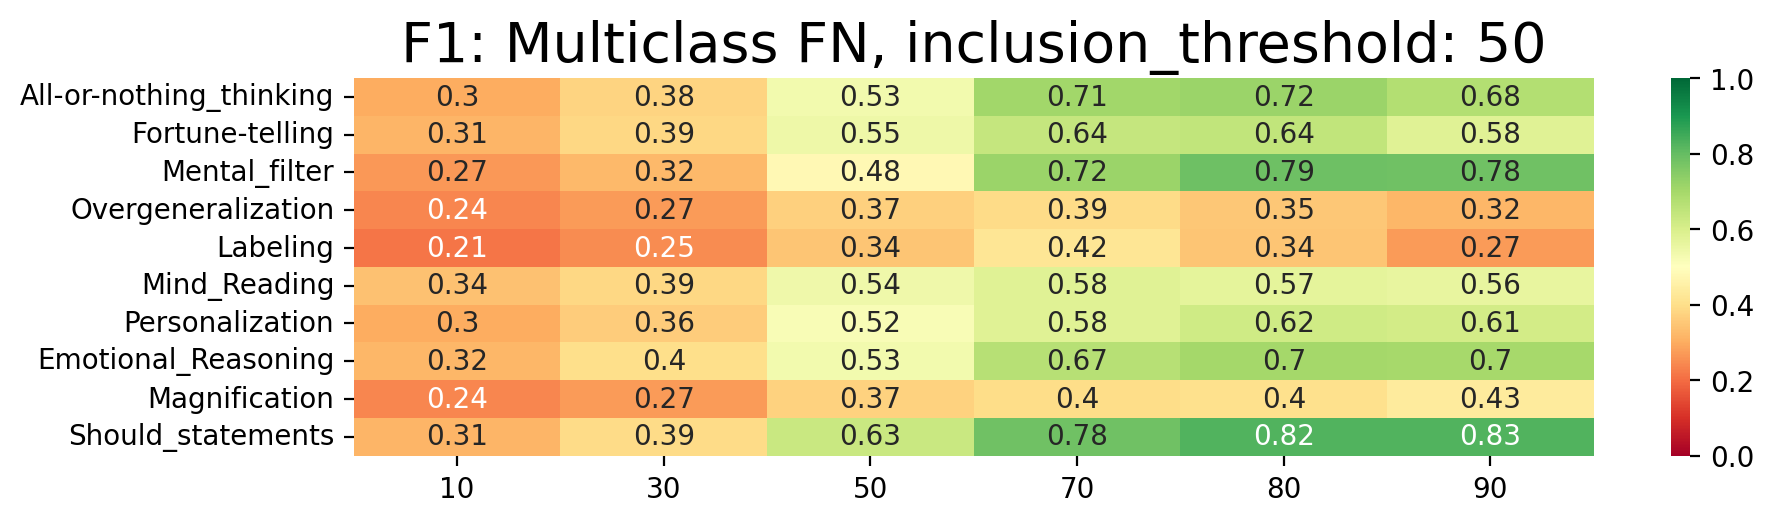

3 4530 3020 1510
defaultdict(<class 'int'>, {'Mind_Reading': 287, 'Overgeneralization': 293, 'Magnification': 270, 'Labeling': 246, 'Personalization': 228, 'Fortune-telling': 231, 'Emotional_Reasoning': 219, 'Mental_filter': 223, 'Should_statements': 213, 'All-or-nothing_thinking': 198, 'No_Distortion': 612})


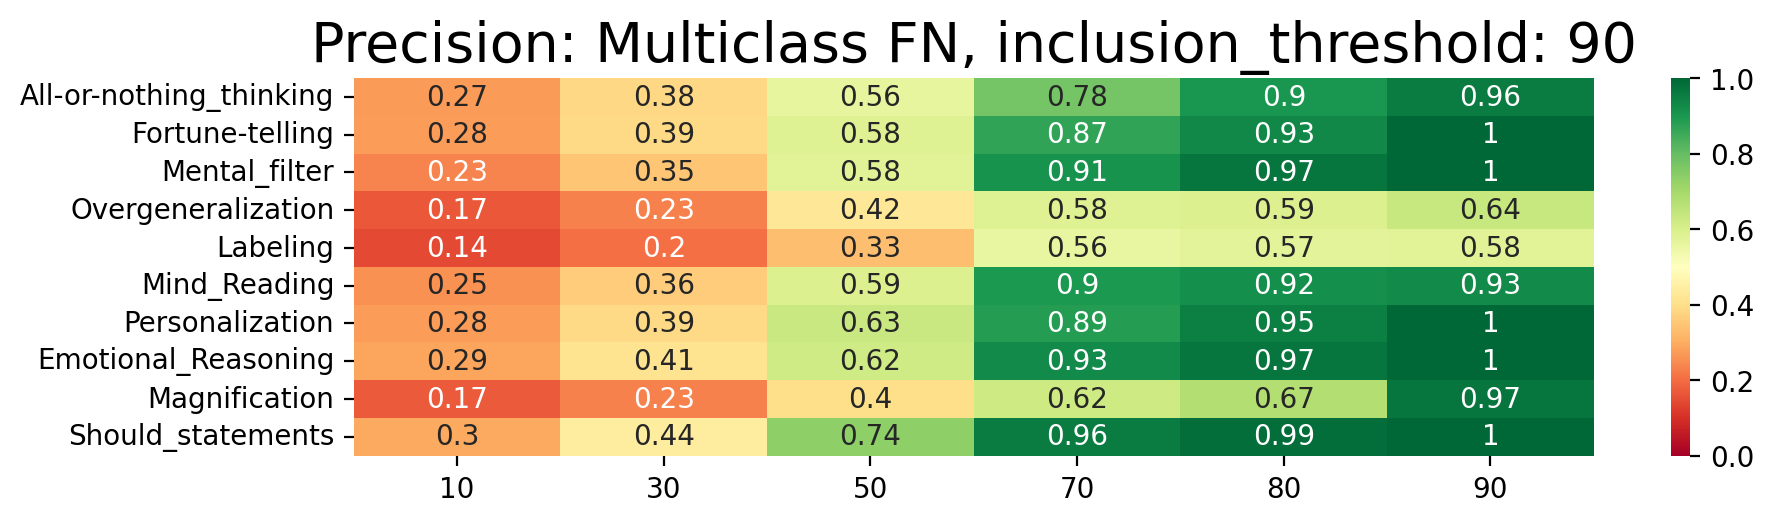

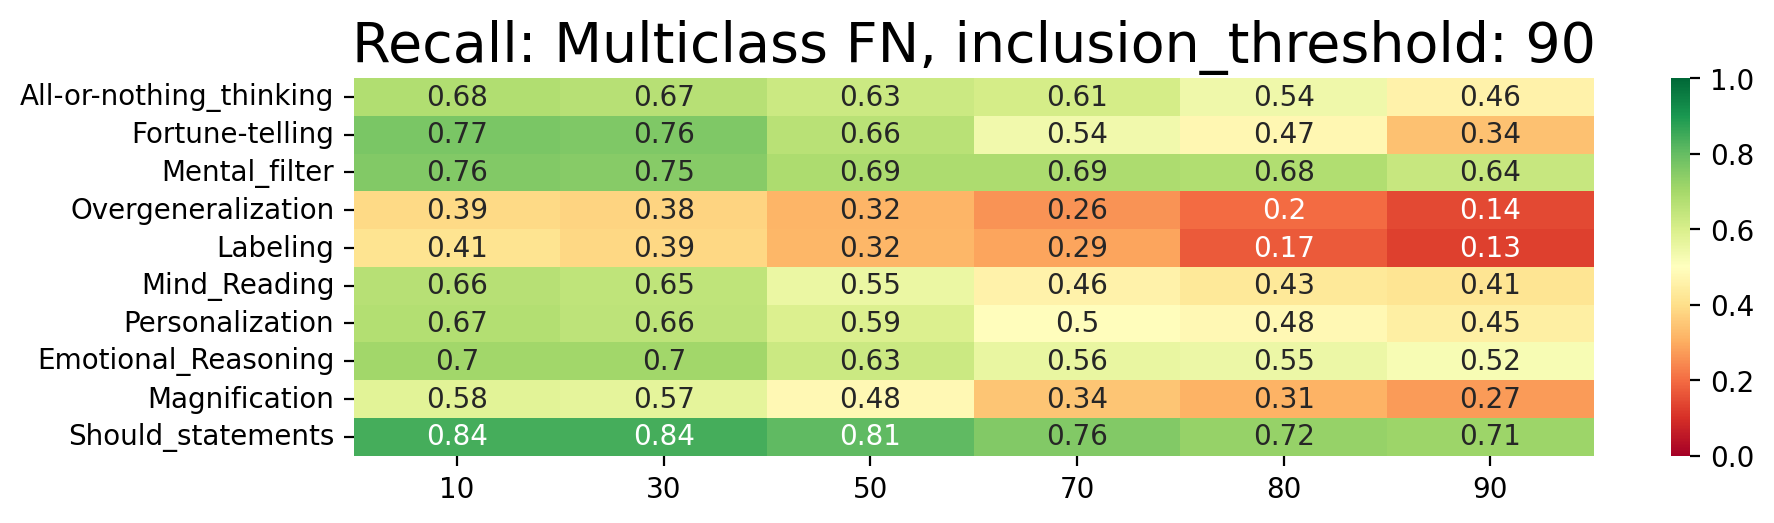

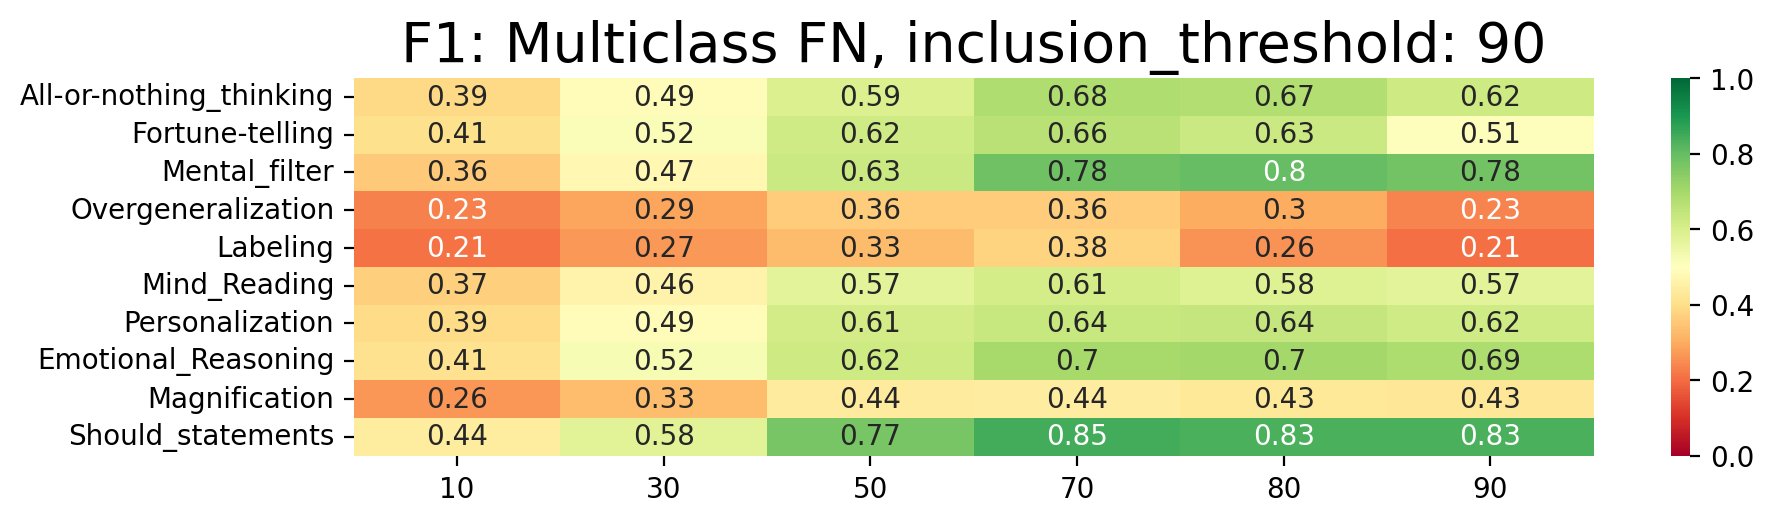

In [16]:
detection_thresholds = [10,30,50,70,80,90]
full_test_circle(df, test_path, 'multi-split-b2', 3, [10], detection_thresholds, all_scores = True)
full_test_circle(df, test_path, 'multi-split-b2', 3, [50], detection_thresholds, all_scores = True)
full_test_circle(df, test_path, 'multi-split-b2', 3, [90], detection_thresholds, all_scores = True)


## Dataset 2 Sagarika Shreevastava

In [17]:
# Dataset: Multiple Distorions (sagarikashreevastava)
# Paper: https://aclanthology.org/2021.clpsych-1.17/
# Data: https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset

# !pip install kagglehub
import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"

df2 = pd.read_csv(multiclass_dataset_file_path) 
df2 = df2.drop('Id_Number', axis=1) # delete columnb with id 

#df = df3[0:5] # hack for test!

df2

Patient Question  \
0     Hello, I have a beautiful,smart,outgoing and a...   
1     Since I was about 16 years old I’ve had these ...   
2      So I’ve been dating on and off this guy for a...   
3     My parents got divorced in 2004. My mother has...   
4     I don’t really know how to explain the situati...   
...                                                 ...   
2525  I’m a 21 year old female. I spent most of my l...   
2526  I am 21 female and have not had any friends fo...   
2527  From the U.S.: My brother is 19 years old and ...   
2528  From the U.S.: I am a 21 year old woman who ha...   
2529  I recently moved out on my ex-roommate because...   

                                         Distorted part Dominant Distortion  \
0     The voice are always fimilar (someone she know...     Personalization   
1     I feel trapped inside my disgusting self and l...            Labeling   
2                                                   NaN       No Distortion   
3                                                   NaN       No Distortion   
4     I refused to go because I didn’t know if it wa...     Fortune-telling   
...                                                 ...                 ...   
2525                                                NaN       No Distortion   
2526  Now I am at university my peers around me all ...  Overgeneralization   
2527  He claims he’s severely depressed and has outb...       Mental filter   
2528                                                NaN       No Distortion   
2529                                                NaN       No Distortion   

     Secondary Distortion (Optional)  
0                                NaN  
1                Emotional Reasoning  
2                                NaN  
3                                NaN  
4                Emotional Reasoning  
...                              ...  
2525                             NaN  
2526                             NaN  
2527                    Mind Reading  
2528                             NaN  
2529                             NaN  

[2530 rows x 4 columns]

In [18]:
data2 = df2labeled(df2)


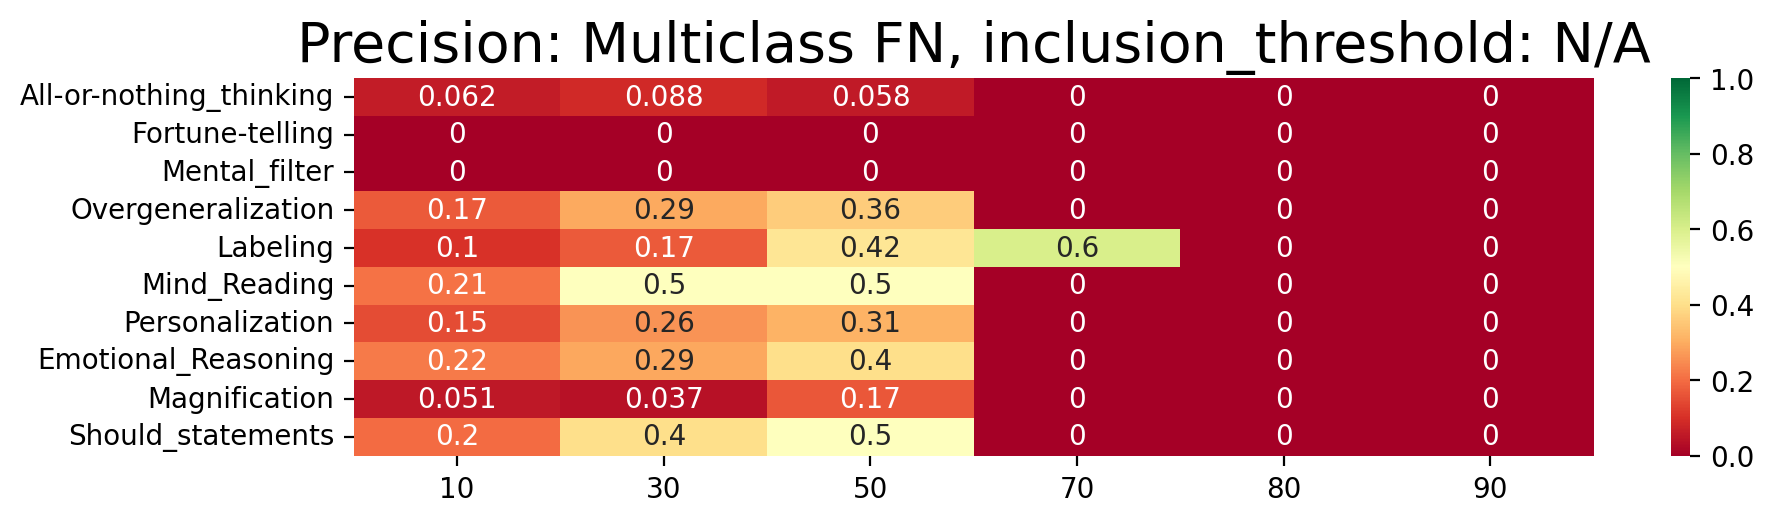

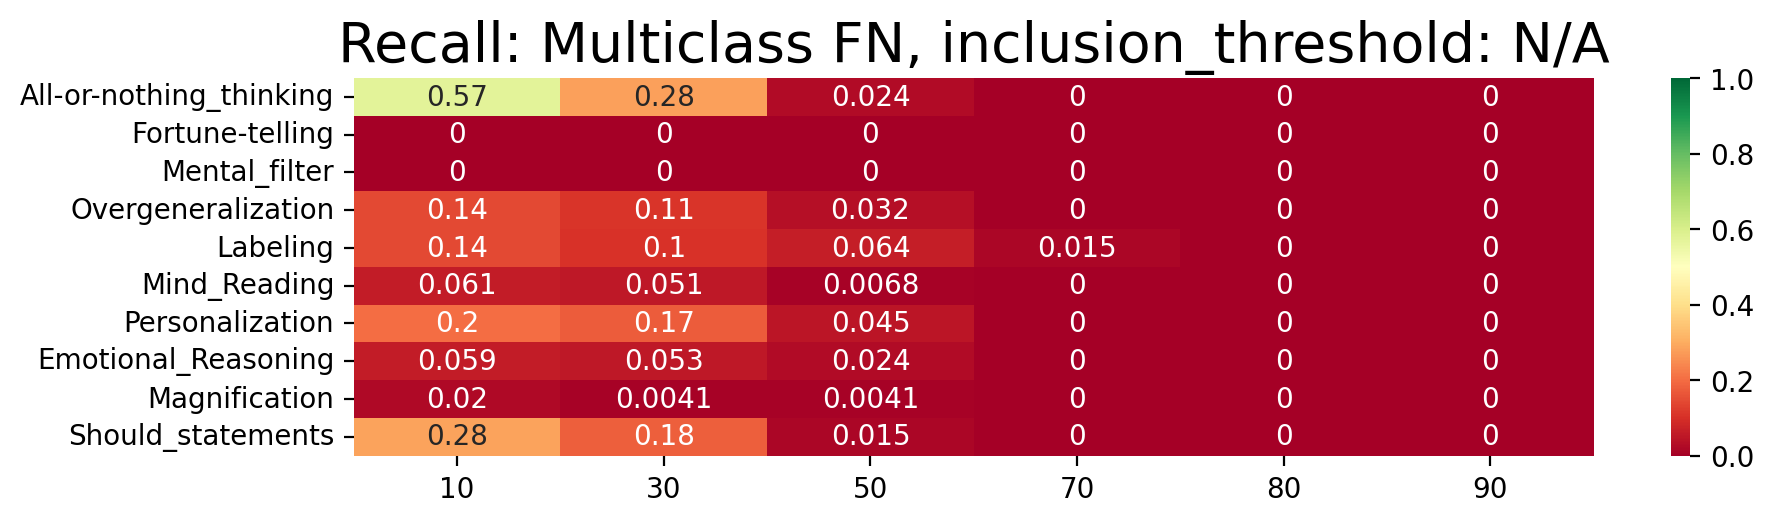

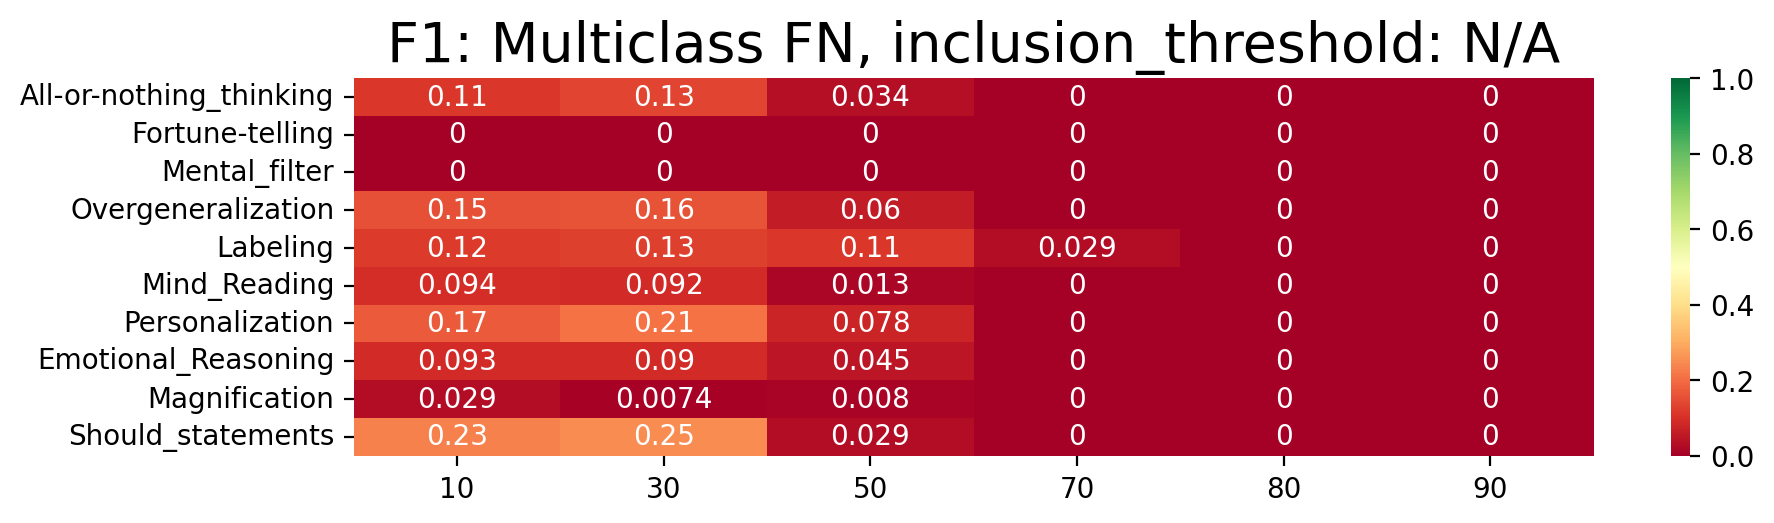

In [19]:
detection_thresholds = [10,30,50,70,80,90]
evaluate_metrics(tm_base, df2, 'N/A', detection_thresholds, all_scores = True)


In [20]:
print(len([t[0] for t in data2 if 'Labeling' in t[1]]))
for t in data2:
    if 'Labeling' in t[1]:
        print(t[0],'=>',t[1])

203
I feel trapped inside my disgusting self and like I’m willing to do anything to escape it.I’m just afraid sometimes that since I’m not really thinking during these times that I might do something to myself–especially since I think during these times that I don’t deserve to get help or that I’m not worth disturbing people by calling them. => ('Labeling', 'Emotional_Reasoning')
I thought that he displayed traits of honor, loyalty, integrity, honesty, and kind-heartedness, as well as characteristics of a hard worker, and an overall well-rounded individual. => ('Labeling',)
I am highly disorganized, I’m concerned with being diagnosed with schizophrenia or something like that => ('Labeling', 'Mental_filter')
We had the storybook romance: we were always happy, never argued, never tired of each other, and all of of friends and family looked at us as having the perfect relationship => ('Labeling',)
I have grown very much but he has not. He will not deal with any issues between us. He is re

3 2530 1686 844
defaultdict(<class 'int'>, {'Labeling': 142, 'Emotional_Reasoning': 105, 'No_Distortion': 612, 'Fortune-telling': 140, 'Mind_Reading': 191, 'Personalization': 128, 'All-or-nothing_thinking': 82, 'Mental_filter': 111, 'Overgeneralization': 187, 'Should_statements': 101, 'Magnification': 172})


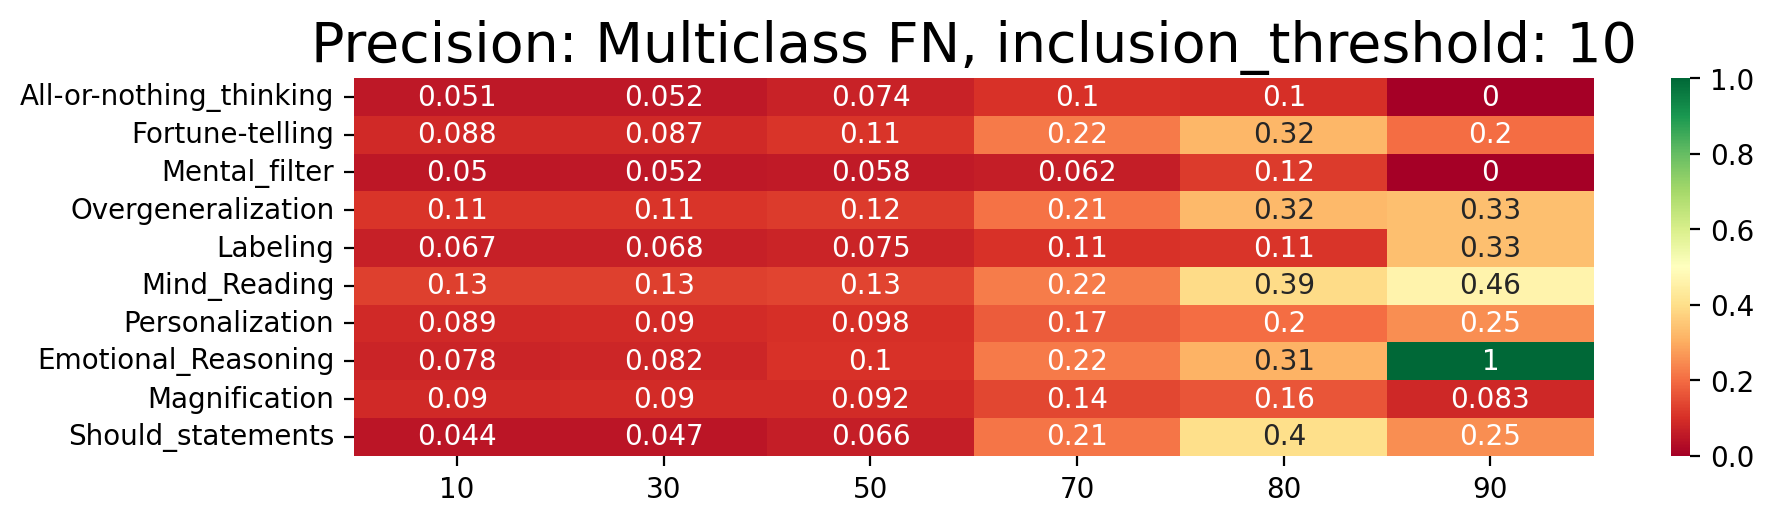

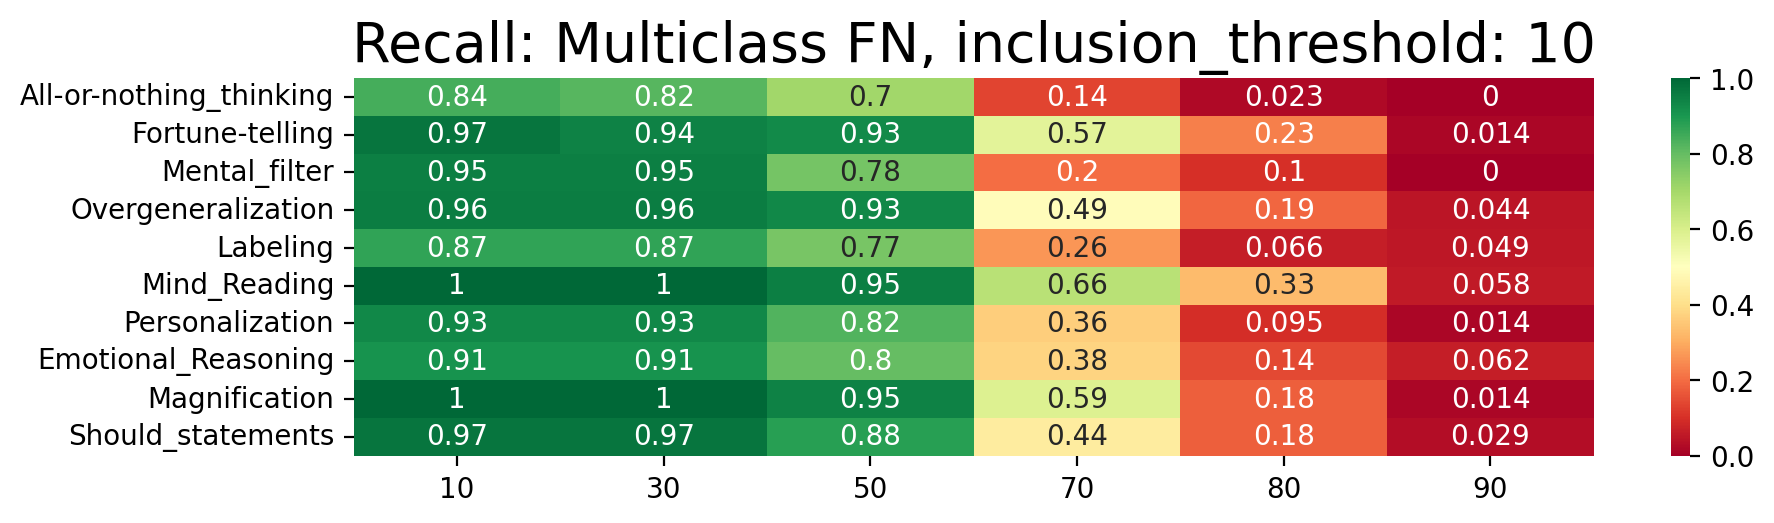

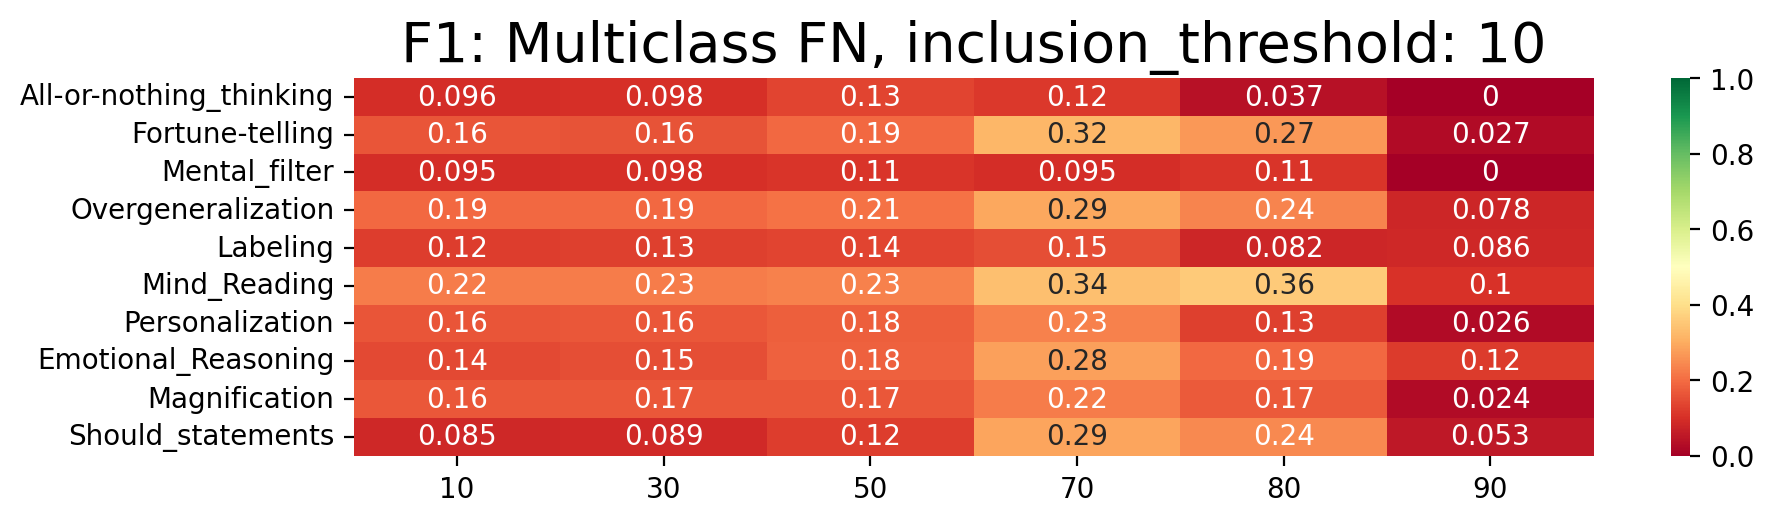

3 2530 1686 844
defaultdict(<class 'int'>, {'Labeling': 142, 'Emotional_Reasoning': 105, 'No_Distortion': 612, 'Fortune-telling': 140, 'Mind_Reading': 191, 'Personalization': 128, 'All-or-nothing_thinking': 82, 'Mental_filter': 111, 'Overgeneralization': 187, 'Should_statements': 101, 'Magnification': 172})


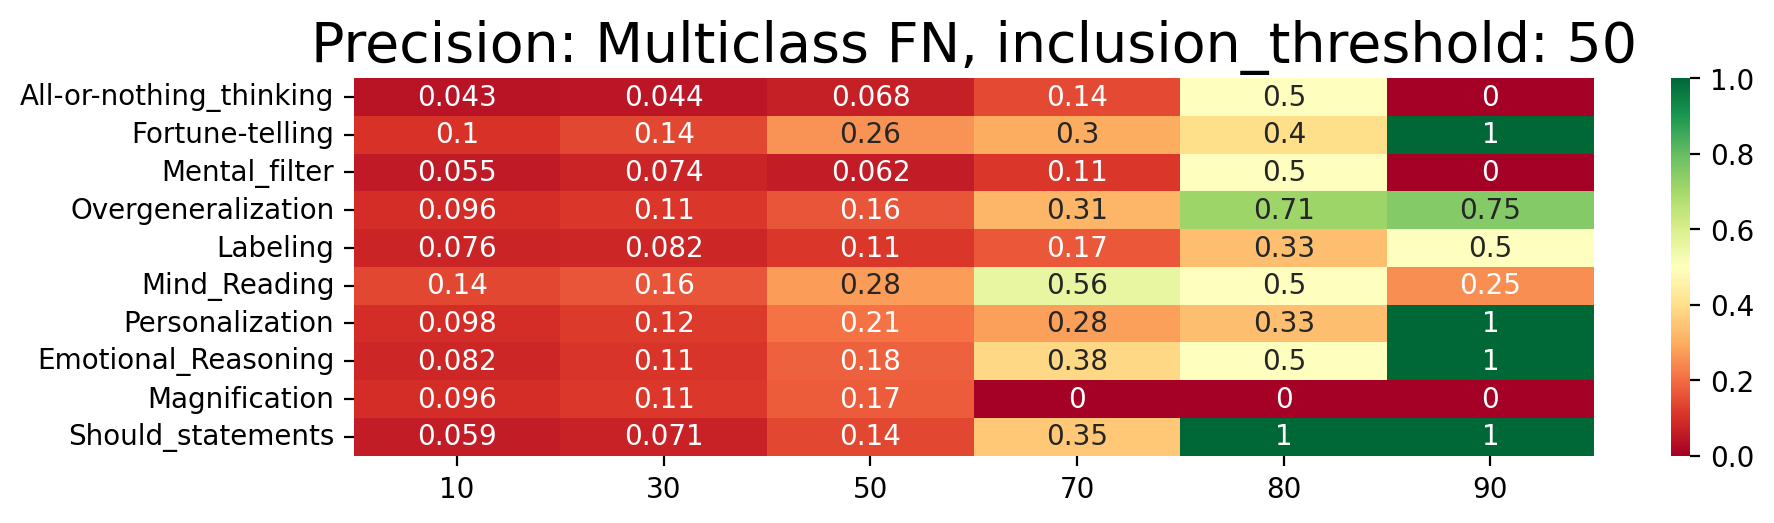

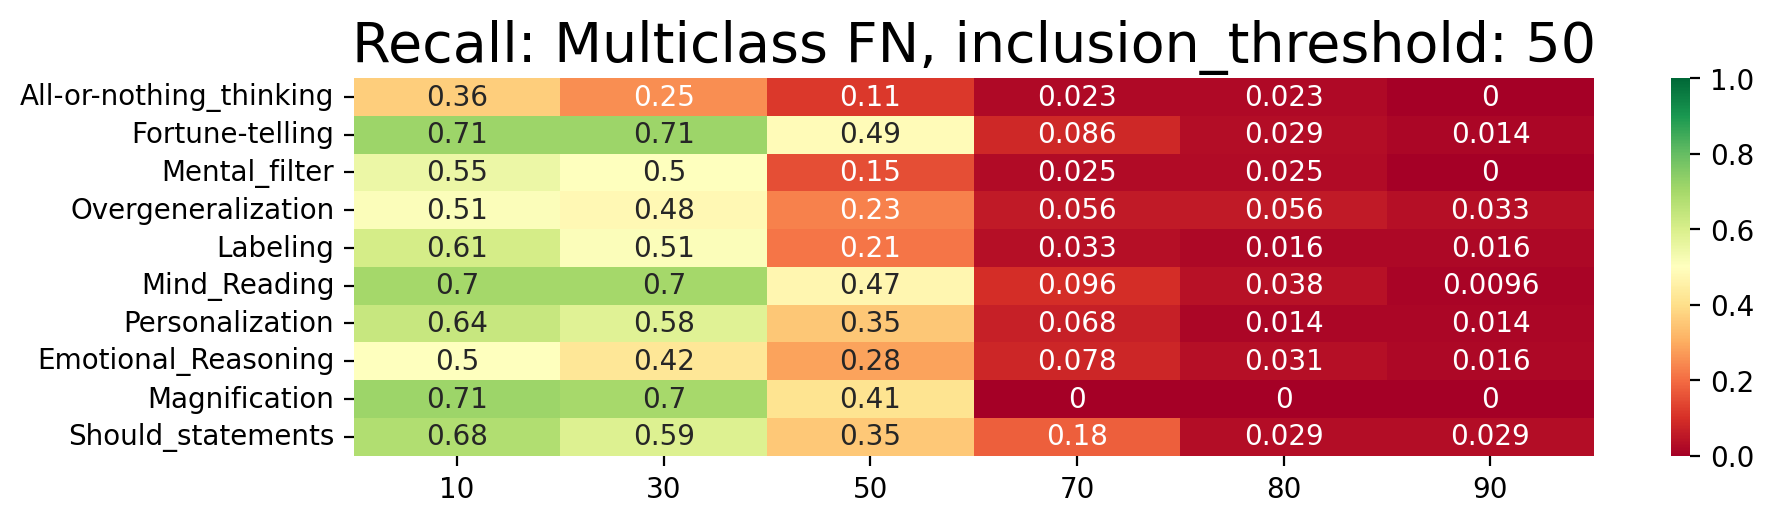

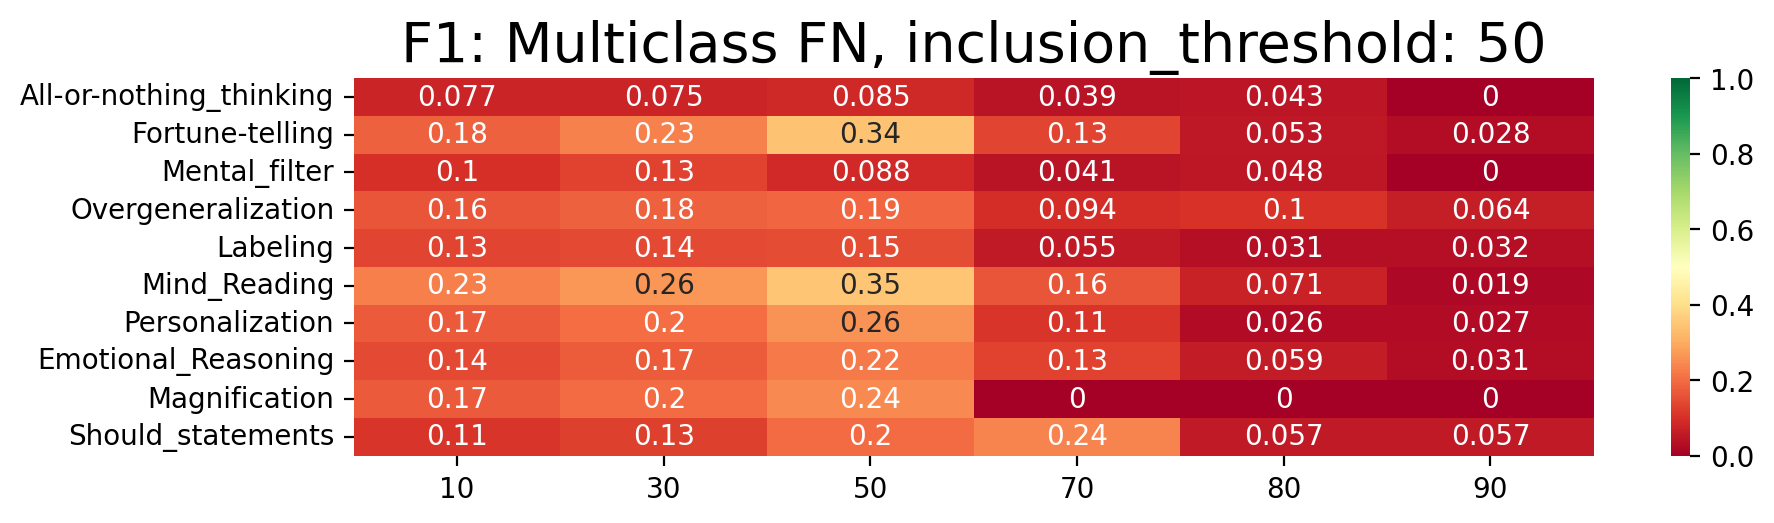

3 2530 1686 844
defaultdict(<class 'int'>, {'Labeling': 142, 'Emotional_Reasoning': 105, 'No_Distortion': 612, 'Fortune-telling': 140, 'Mind_Reading': 191, 'Personalization': 128, 'All-or-nothing_thinking': 82, 'Mental_filter': 111, 'Overgeneralization': 187, 'Should_statements': 101, 'Magnification': 172})


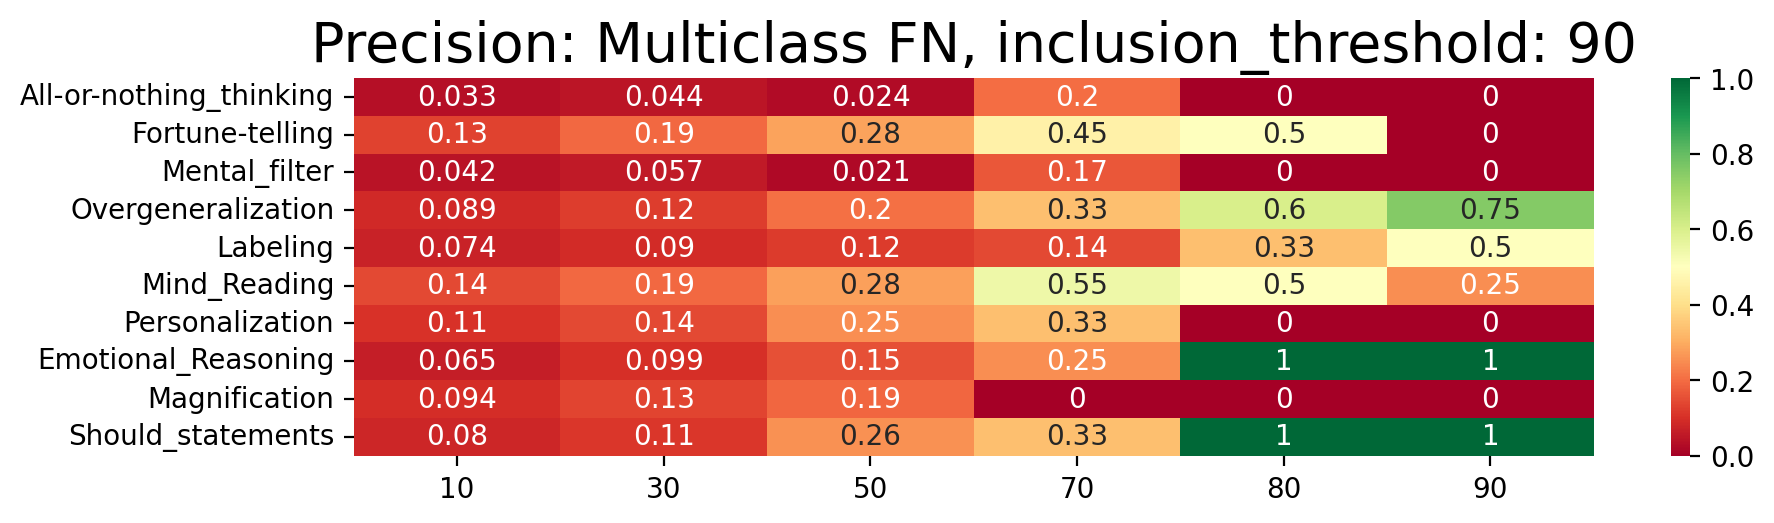

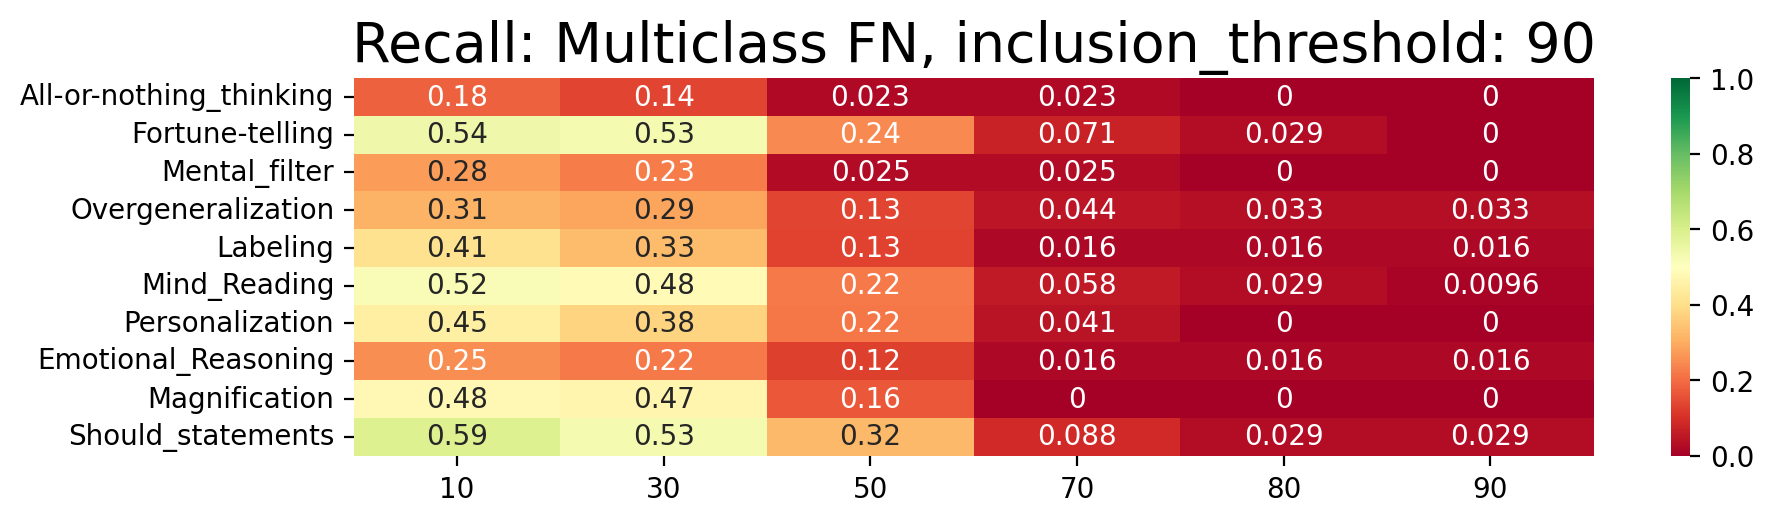

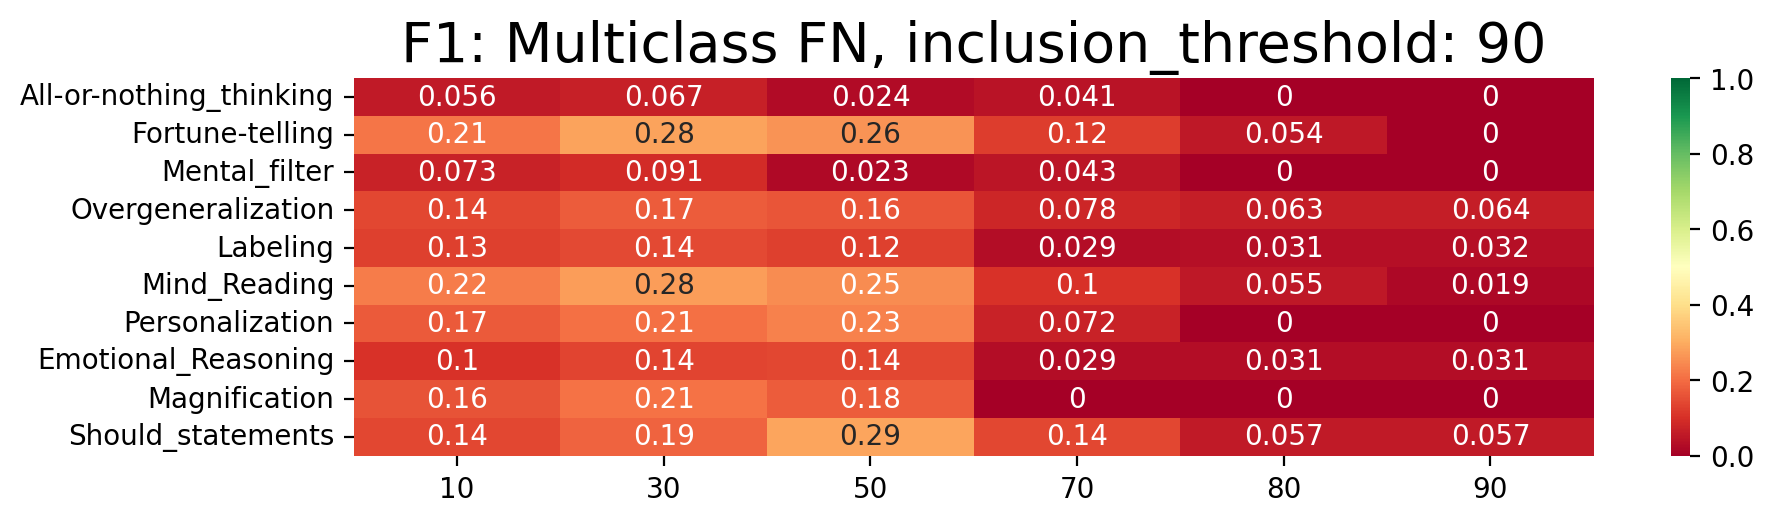

In [21]:
detection_thresholds = [10,30,50,70,80,90]
full_test_circle(df2, test_path, 'multi-split-df2', 3, [10], detection_thresholds, all_scores = True)
full_test_circle(df2, test_path, 'multi-split-df2', 3, [50], detection_thresholds, all_scores = True)
full_test_circle(df2, test_path, 'multi-split-df2', 3, [90], detection_thresholds, all_scores = True)


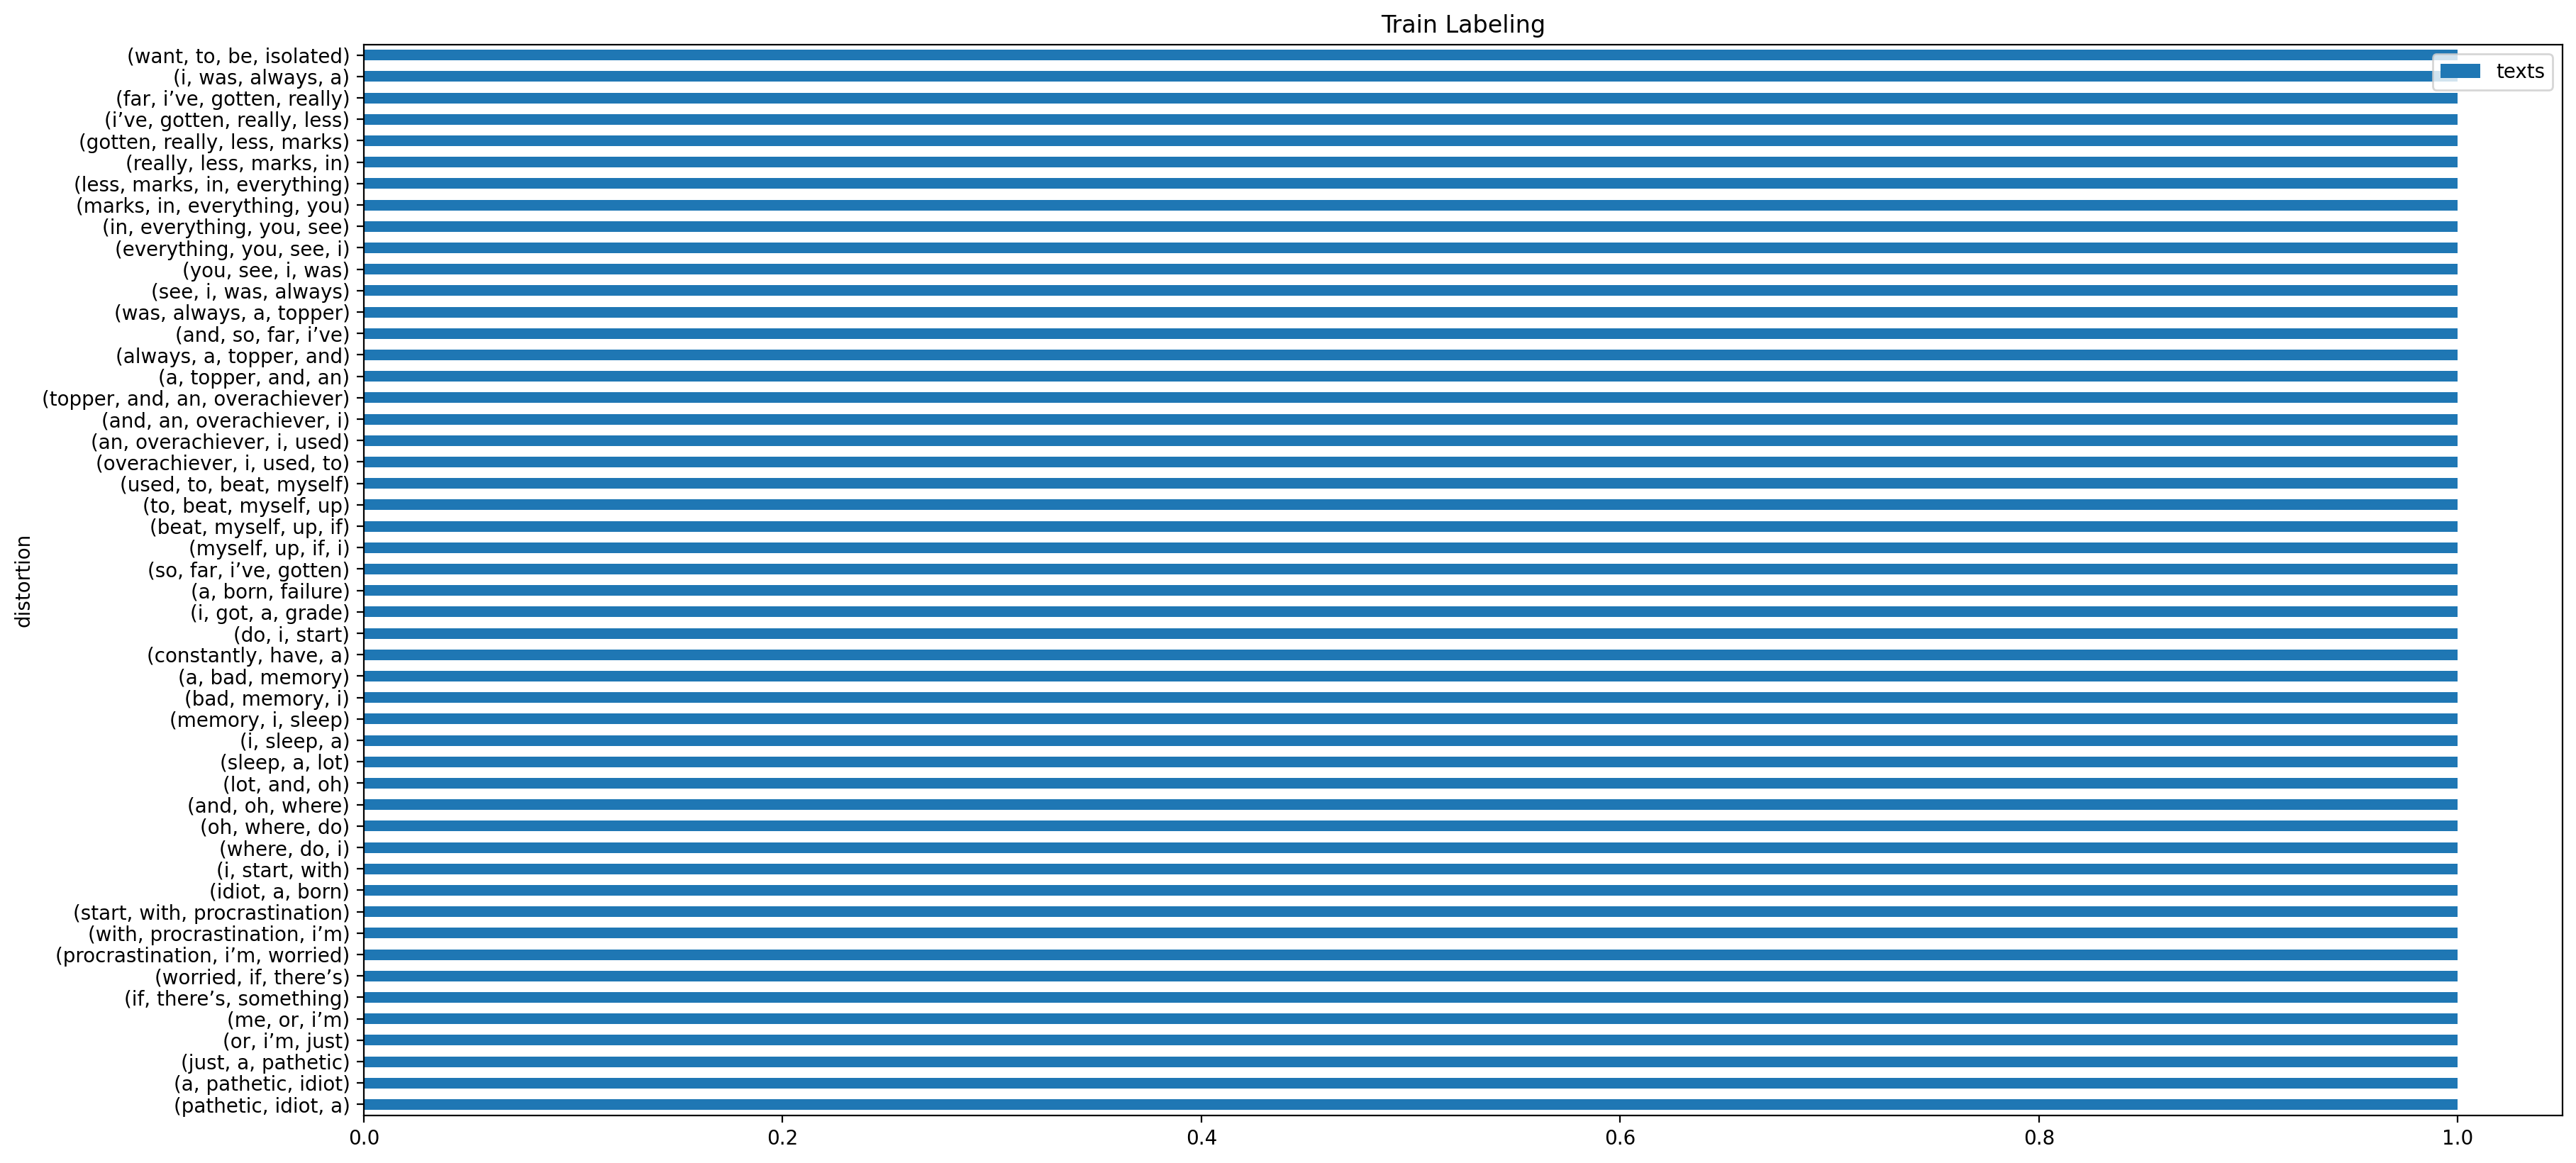

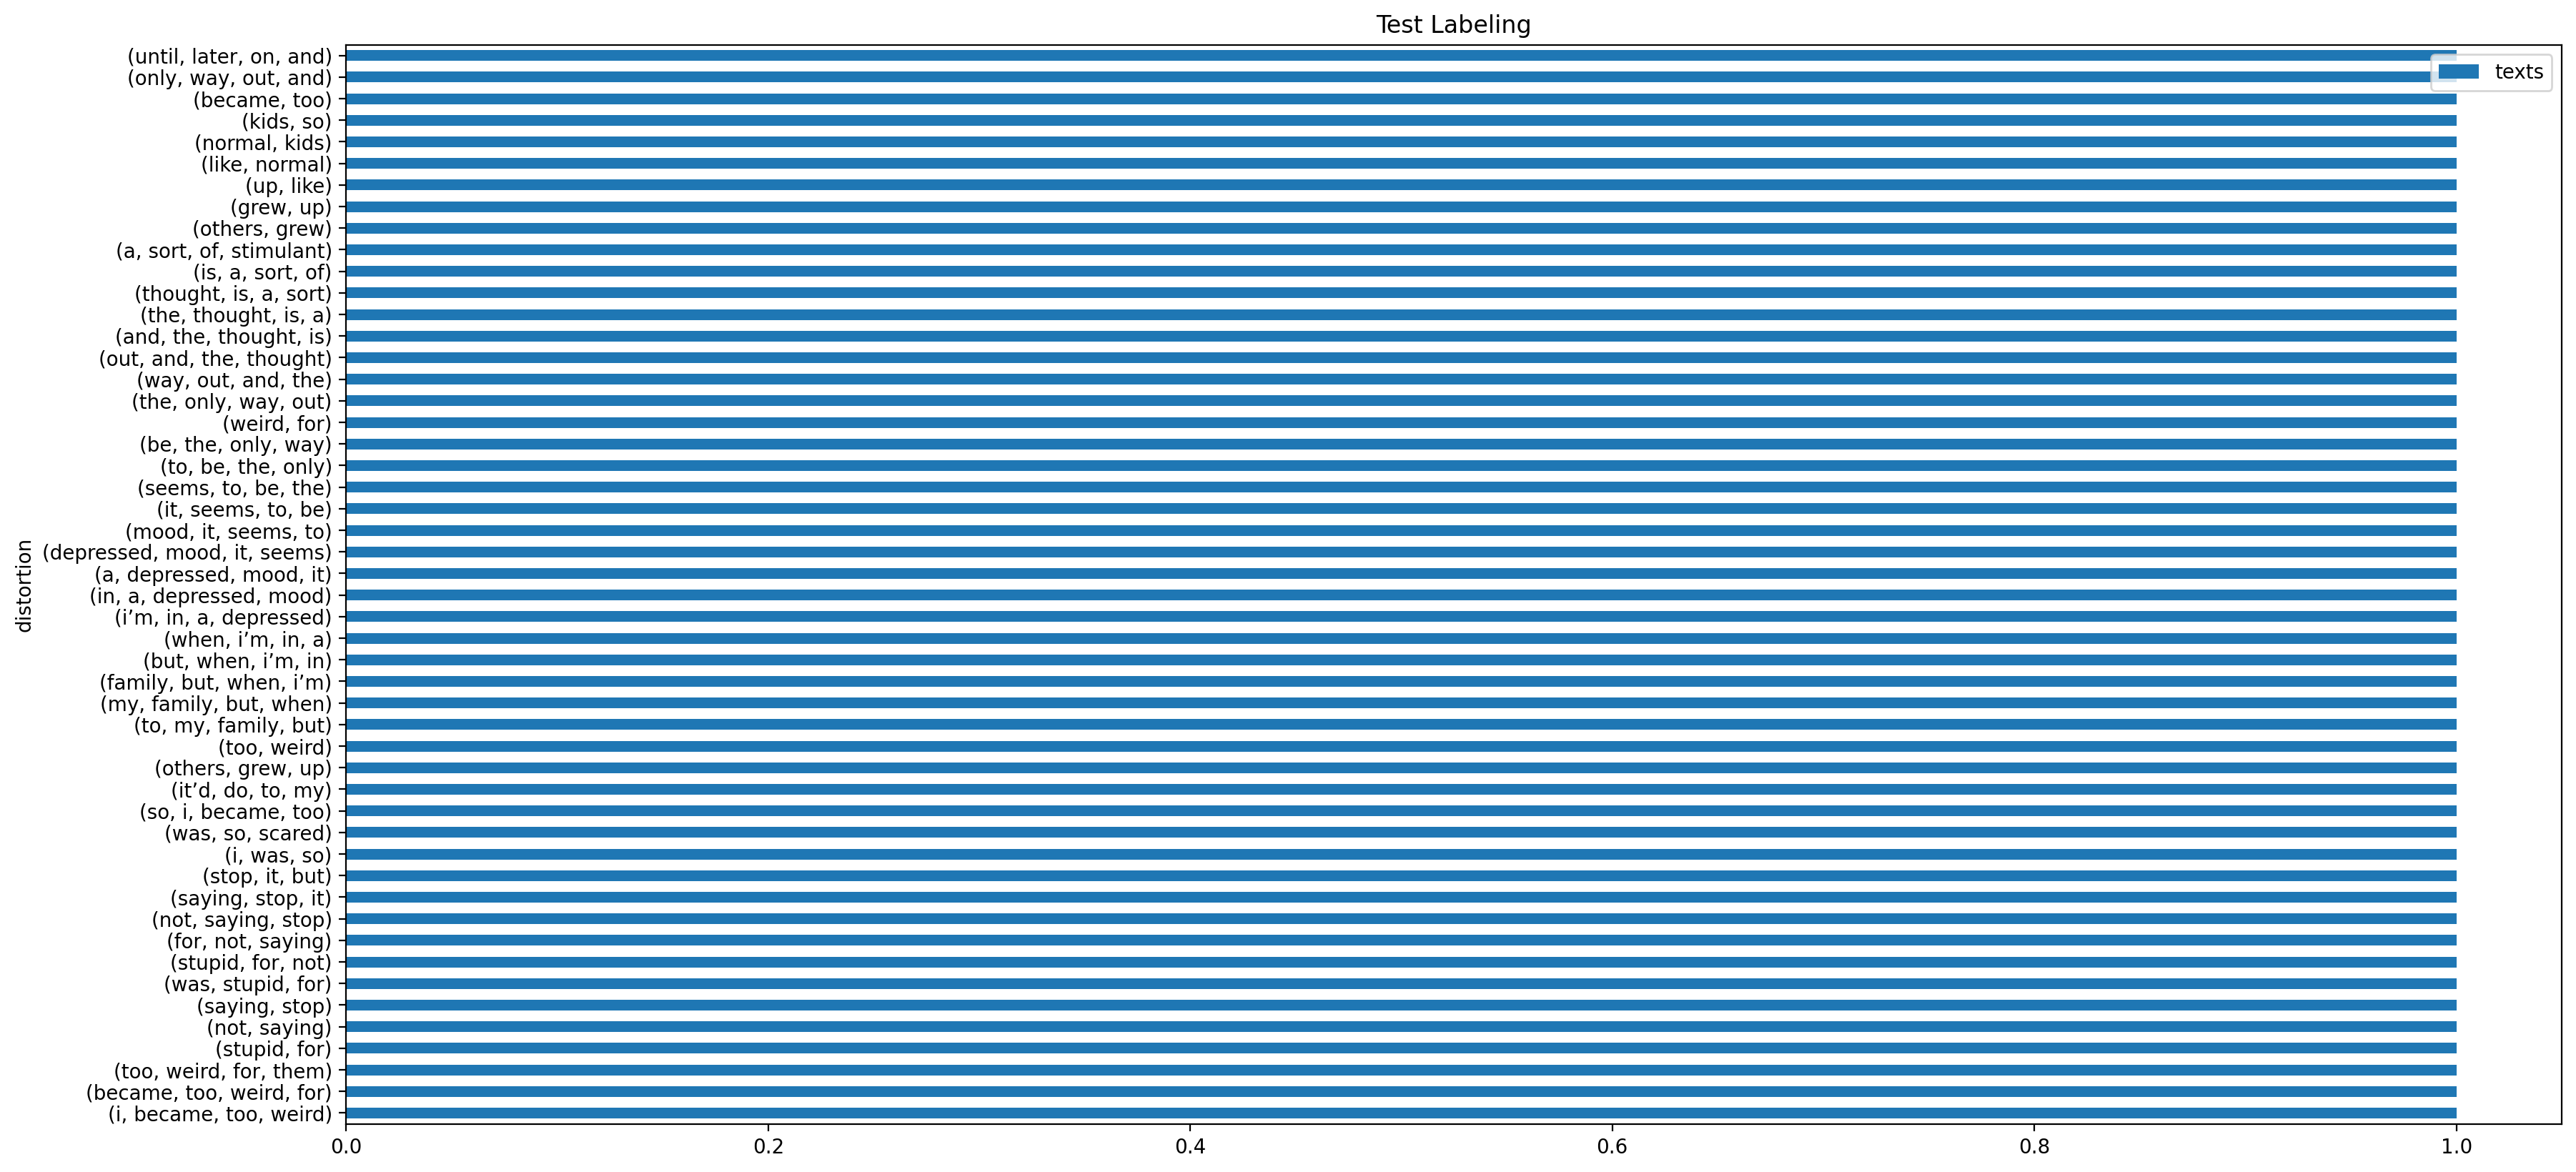

In [22]:
validation_fraction = 10
train = df2labeled(df[df.index % validation_fraction != 0])
test = df2labeled(df[df.index % validation_fraction == 0])

train_model=Learner()
train_model.learn(train, punctuation = punct, debug = False)
train_model.normalize()
train_model.metrics['FN']['Labeling']

test_model=Learner()
test_model.learn(test, punctuation = punct, debug = False)
test_model.normalize()
test_model.metrics['FN']['Labeling']

plot_dict(
    train_model.metrics['FN']['Labeling'],
    labels="distortion",
    values="texts",
    title="Train Labeling",
    head=50
)
plot_dict(
    test_model.metrics['FN']['Labeling'],
    labels="distortion",
    values="texts",
    title="Test Labeling",
    head=50
)


### Experiment with Pre-Training

In [23]:
def load_text_lines(dest_list,path,encoding=None,debug=False):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    if debug:
        print(len(onlyfiles))
    for file in onlyfiles:
        with open(join(path, file), encoding=encoding) as f:
            try:
                lines = f.readlines()
                dest_list.extend(lines)
            except UnicodeDecodeError:
                print('UnicodeDecodeError',join(path, file))
            if debug:
                print(join(path, file),len(lines))


In [24]:
file = open('large_ngram_model', 'rb')
train_model = pickle.load(file)
file.close()

In [25]:
train_model.all_n_grams[('the',)]

2300572

In [26]:
validation_fraction = 10
train_df = df2[df2.index % validation_fraction != 0]
test_df = df2[df2.index % validation_fraction == 0]
train = df2labeled(train_df)
test = df2labeled(test_df)
len(test_df)+len(train_df)

2530

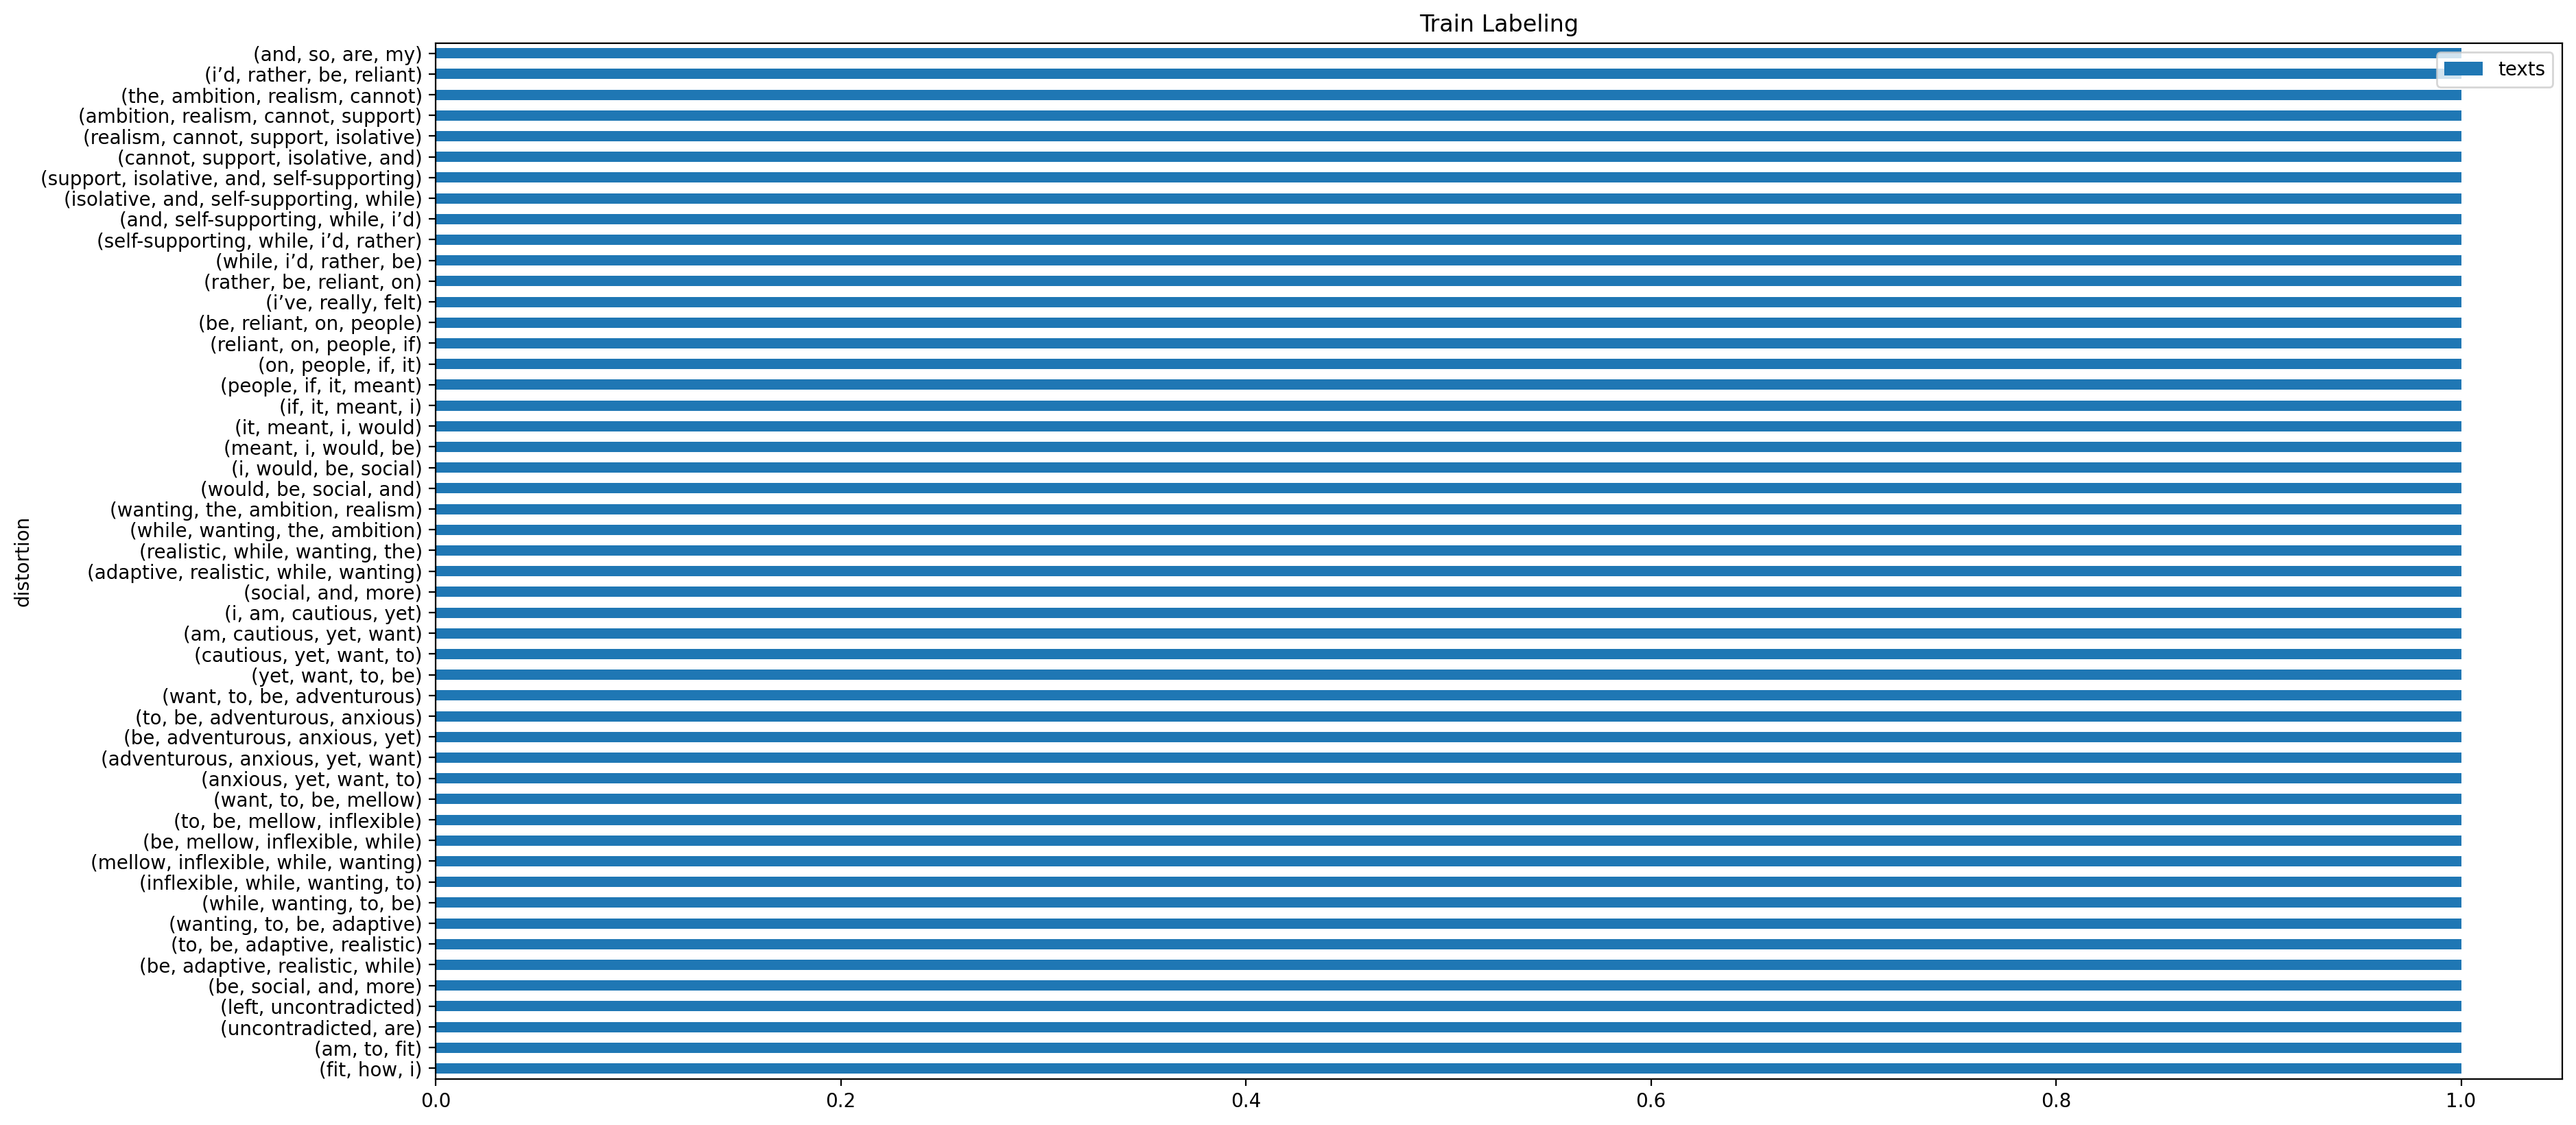

In [27]:
train_model.learn(train, punctuation = punct, sent=True, debug = False)
train_model.normalize()
train_model.metrics['FN']['Labeling']

plot_dict(
    train_model.metrics['FN']['Labeling'],
    labels="distortion",
    values="texts",
    title="Train Labeling",
    head=50
)


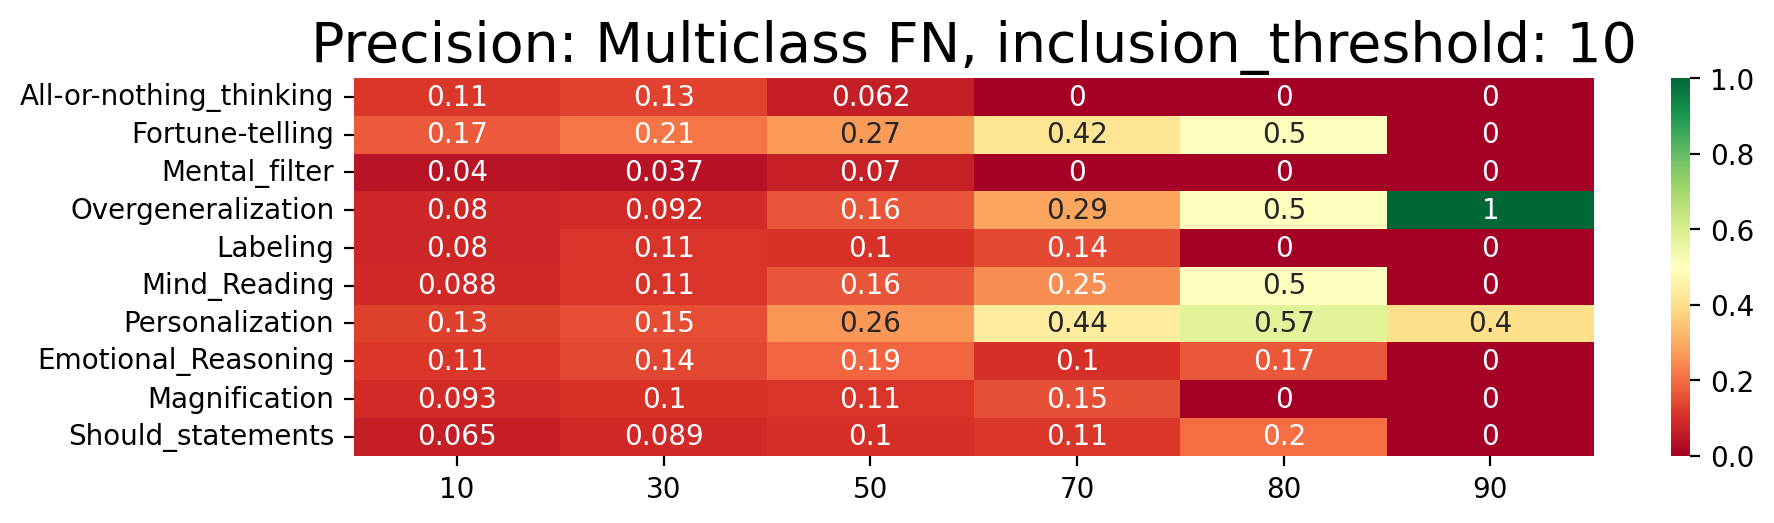

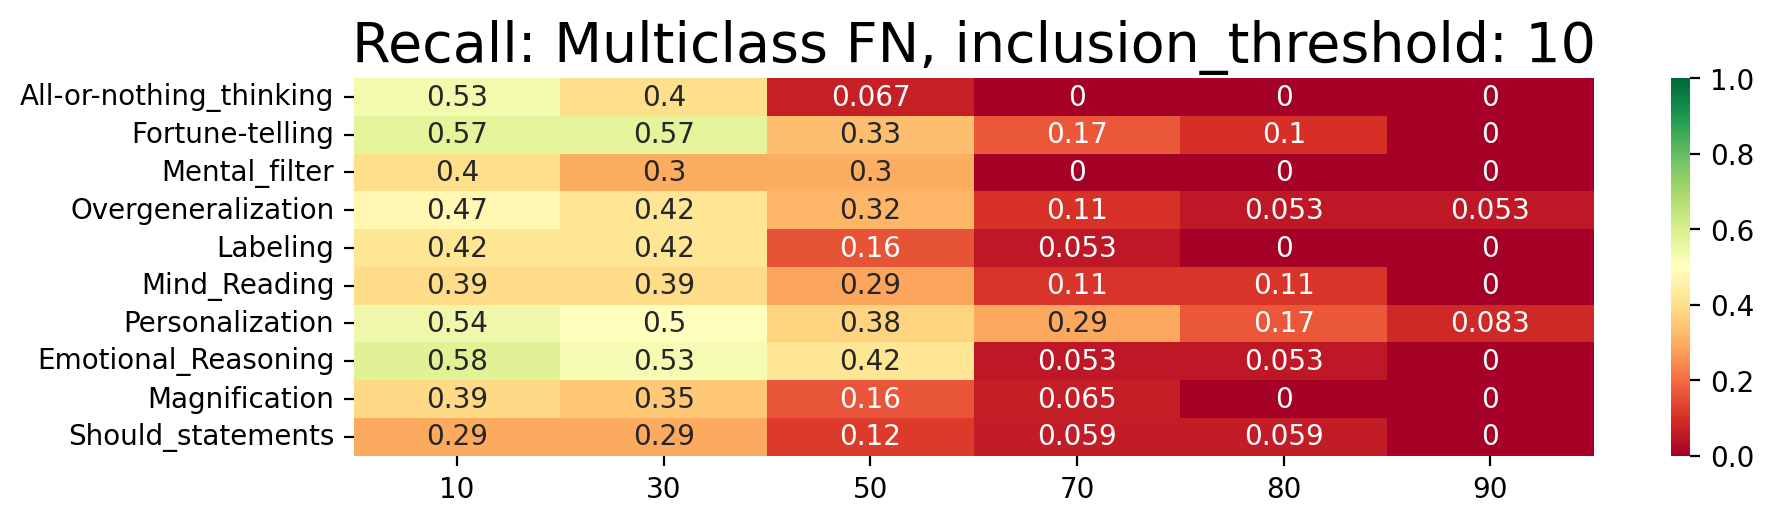

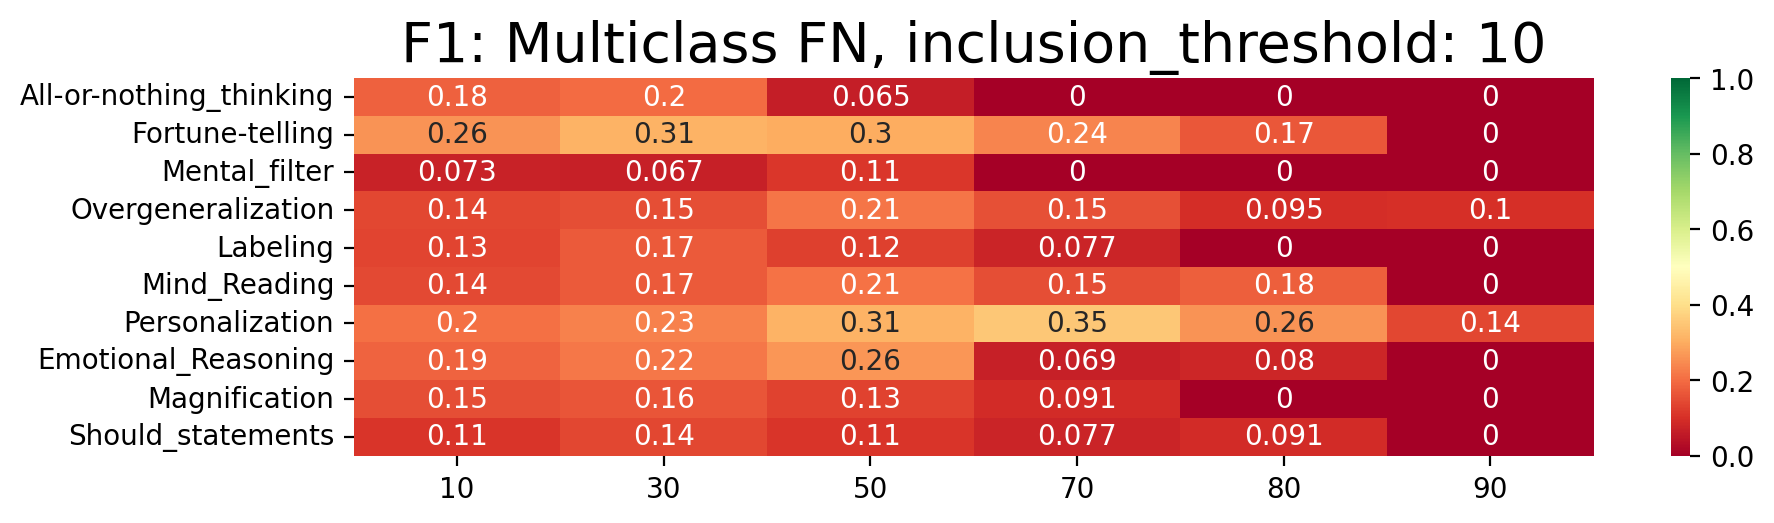

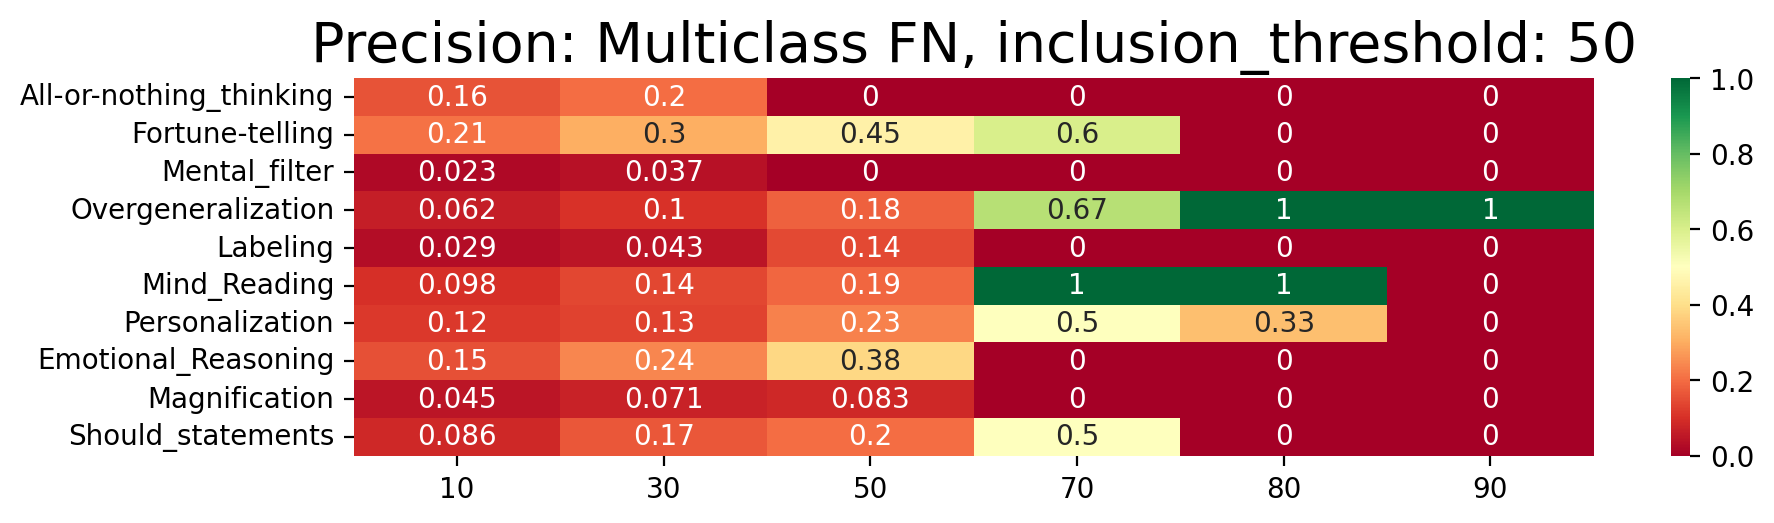

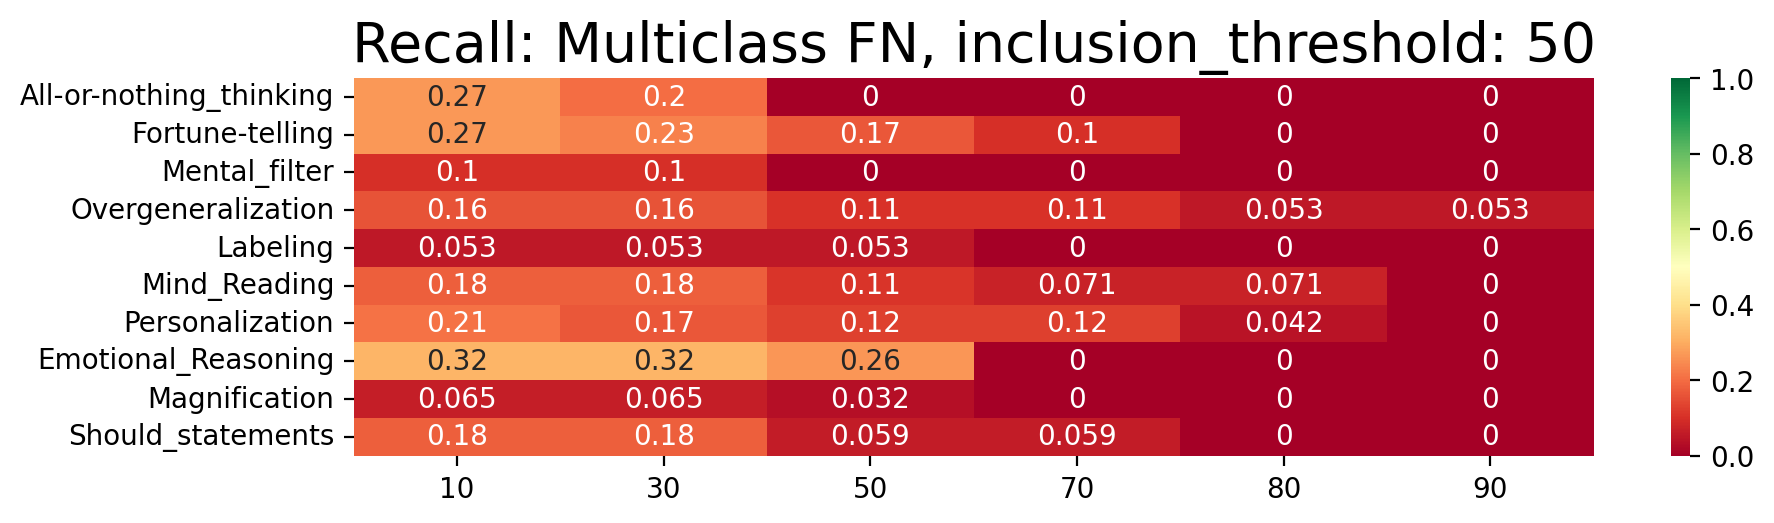

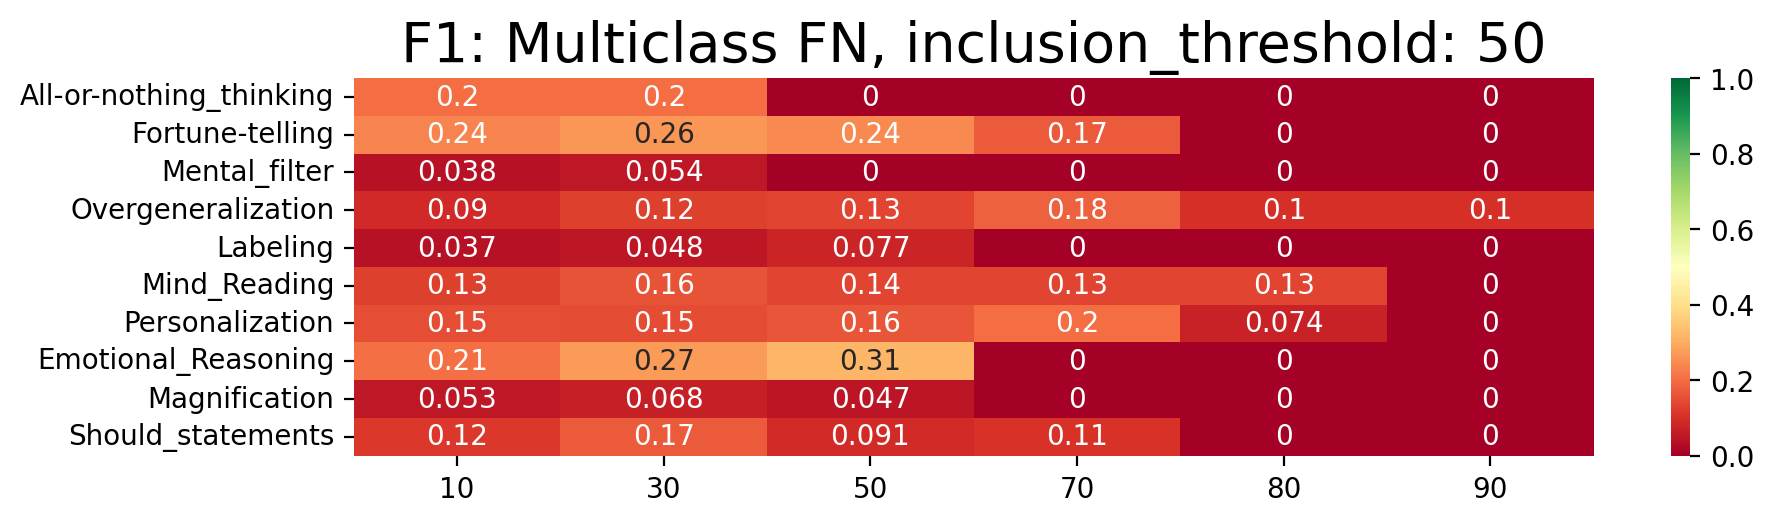

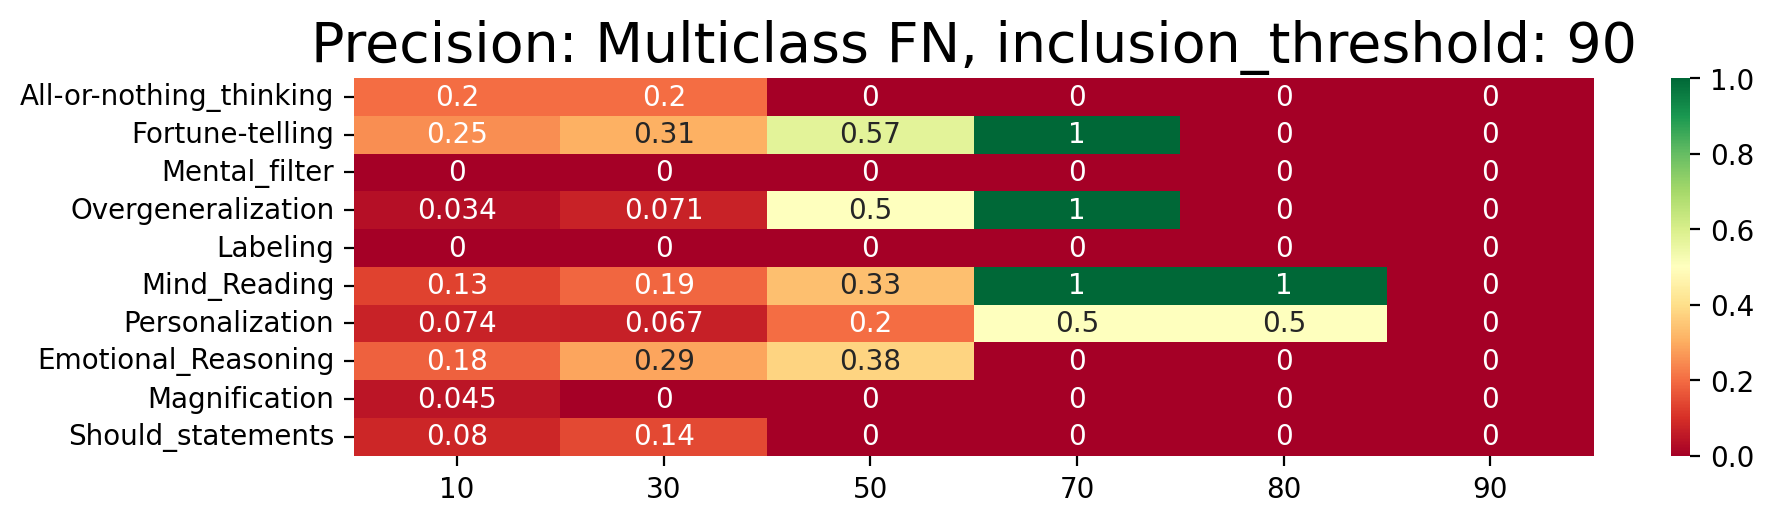

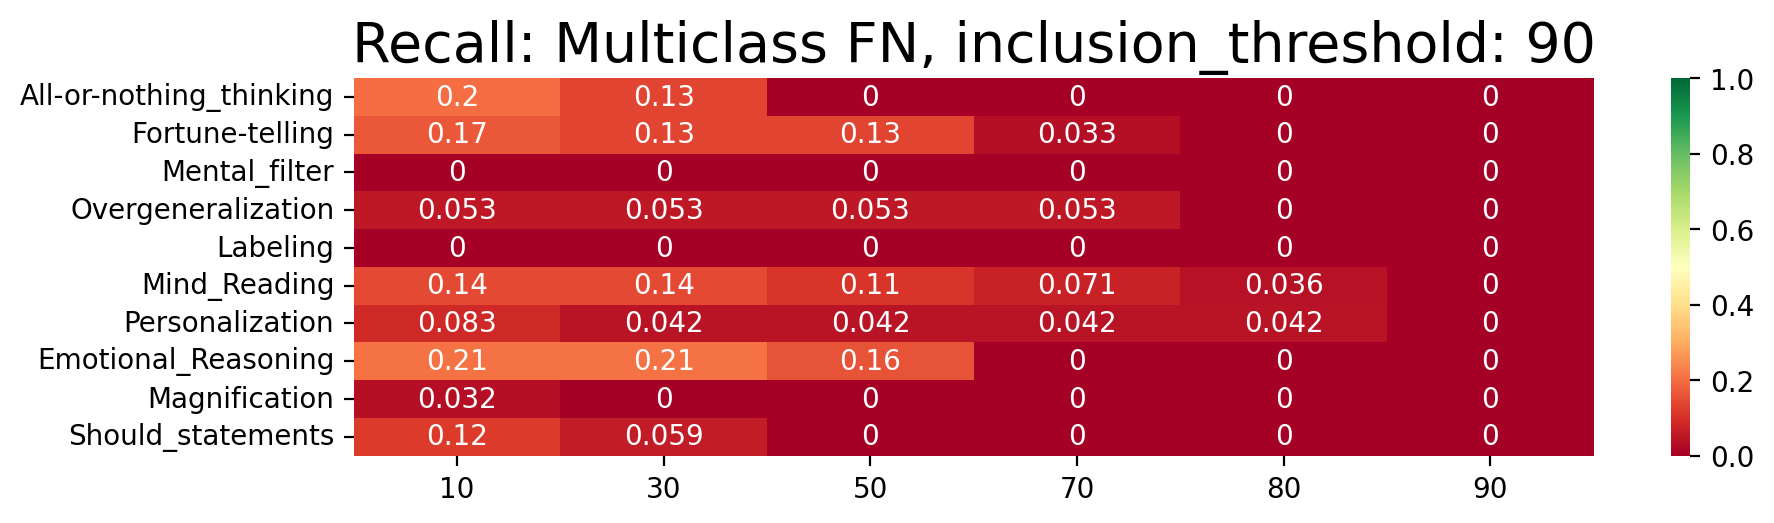

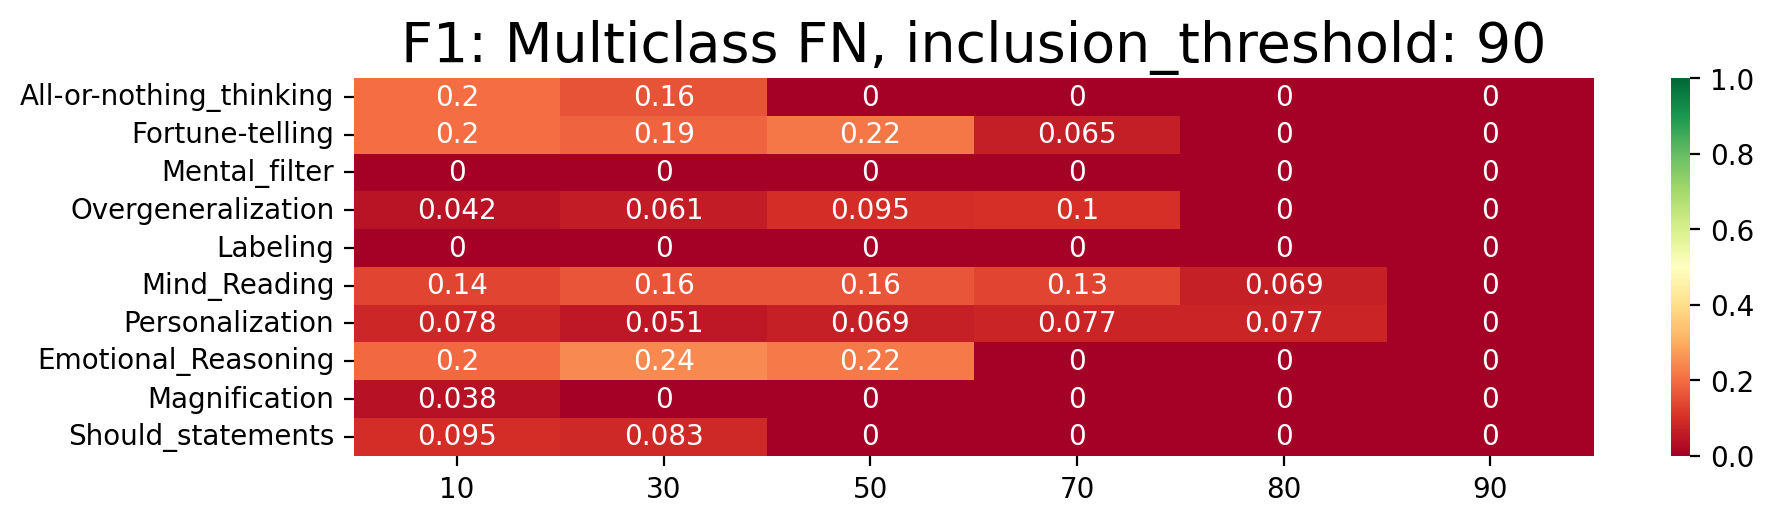

In [28]:
detection_thresholds = [10,30,50,70,80,90]
evaluate_model(train_model, test_df, test_path, 'multi-split-b2-exp', 3, [10], detection_thresholds, all_scores = True)
evaluate_model(train_model, test_df, test_path, 'multi-split-b2-exp', 3, [50], detection_thresholds, all_scores = True)
evaluate_model(train_model, test_df, test_path, 'multi-split-b2-exp', 3, [90], detection_thresholds, all_scores = True)
